# Psychedelic experience data

1-40Hz filter, 4 microstates
Correlations among experience data and microstate statistics

In [1]:
%matplotlib inline

import os
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
from IPython.display import display
from pingouin.multicomp import multicomp
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA

from src.helpers import DATA_ROOT, PLOTS_ROOT, RESULTS_ROOT, make_dirs

plt.style.use("default")
plt.rcParams["legend.frameon"] = False
plt.rcParams["figure.figsize"] = (20, 9)
sns.set_context("notebook", font_scale=1.75)

MS_STATS_ROOT = os.path.join(RESULTS_ROOT, "20260116-new-recompute")
WORKING_DIR = os.path.join(RESULTS_ROOT, "experience")
if not os.path.exists(WORKING_DIR):
    make_dirs(WORKING_DIR)
PLOTTING_DIR = os.path.join(PLOTS_ROOT, "new")
if not os.path.exists(PLOTTING_DIR):
    make_dirs(PLOTTING_DIR)

# if True, will save all statistical tests as csv and all plots as eps
SAVE_RESULTS = True
PLOT_EXT = ".eps"
# which correction for multiple comparisons should be used
MULTI_CORRECTION = "fdr_bh"
PVAL_STARS = {0.001: "***", 0.01: "**", 0.05: "*"}

In [2]:
experience = pd.read_csv(
    os.path.join(DATA_ROOT, "experience_data", "experience_processed.csv")
)
experience = experience.rename(columns={"group": "condition"})

persisting_effs = pd.read_csv(
    os.path.join(
        DATA_ROOT, "experience_data", "persisting_effects_scale_processed.csv"
    )
)
persisting_effs = persisting_effs.rename(columns={"group": "condition"})

ms_stats = pd.read_csv(
    os.path.join(MS_STATS_ROOT, "ms_stats.csv"), index_col=[0]
)
# divide session into PLA/PSI and time for plotting purposes
ms_stats[["condition", "time"]] = ms_stats["session"].str.split(
    "-", expand=True
)
# divide to filters
# ms_stats_220 = ms_stats[ms_stats["ms_opts"] == "(2.0, 20.0, 4)"]
# ms_stats_220 = ms_stats_220.sort_values(by=["condition", "time"])
ms_stats = ms_stats[ms_stats["ms_opts"] == "(1.0, 40.0, 3)"]
ms_stats = ms_stats.sort_values(by=["condition", "time"]).drop(
    ["template_corr"], axis=1
)

In [3]:
ms_stats

subject session microstate   var_GFP  var_total  coverage  occurrence  \
0         2  PLA-T1          A  0.600064   0.541670  0.347427    6.224392   
1         2  PLA-T1          B  0.600064   0.541670  0.225271    5.499463   
2         2  PLA-T1          C  0.600064   0.541670  0.427302    6.799336   
0         1  PLA-T1          A  0.652601   0.596464  0.304560    6.999316   
1         1  PLA-T1          B  0.652601   0.596464  0.324187    7.099307   
..      ...     ...        ...       ...        ...       ...         ...   
1        17  PSI-T5          B  0.706784   0.661539  0.366859    6.924324   
2        17  PSI-T5          C  0.706784   0.661539  0.211503    5.124500   
0        21  PSI-T5          A  0.843931   0.790400  0.498486    5.074504   
1        21  PSI-T5          B  0.843931   0.790400  0.369593    4.349575   
2        21  PSI-T5          C  0.843931   0.790400  0.131921    2.874719   

     lifespan  transition->A  transition->B  transition->C  transition->D  \
0   55.427797       0.930017       0.027825       0.042159            NaN   
1   40.784801       0.042498       0.904597       0.052905            NaN   
2   62.844669       0.034278       0.027879       0.937843            NaN   
0   43.512835       0.910228       0.040077       0.049695            NaN   
1   45.664613       0.041566       0.914458       0.043976            NaN   
..        ...            ...            ...            ...            ...   
1   52.854242       0.047391       0.926251       0.026358            NaN   
2   41.321998       0.048476       0.046168       0.905355            NaN   
0   98.391089       0.960235       0.025073       0.014691            NaN   
1   82.974138       0.035412       0.954017       0.010571            NaN   
2   45.889946       0.050333       0.034789       0.914878            NaN   

           ms_opts condition time  
0   (1.0, 40.0, 3)       PLA   T1  
1   (1.0, 40.0, 3)       PLA   T1  
2   (1.0, 40.0, 3)       PLA   T1  
0   (1.0, 40.0, 3)       PLA   T1  
1   (1.0, 40.0, 3)       PLA   T1  
..             ...       ...  ...  
1   (1.0, 40.0, 3)       PSI   T5  
2   (1.0, 40.0, 3)       PSI   T5  
0   (1.0, 40.0, 3)       PSI   T5  
1   (1.0, 40.0, 3)       PSI   T5  
2   (1.0, 40.0, 3)       PSI   T5  

[450 rows x 15 columns]

In [4]:
def pd_pca(df, n_comps, col_name=None):
    if col_name is None:
        col_name = ""
    else:
        col_name += "_"
    pca = PCA(n_components=n_comps)
    pcs = pca.fit_transform(df.values)
    loadings = pca.components_[0]
    if loadings.sum() < 0:
        pcs *= -1
        loadings *= -1
    return pd.DataFrame(
        pcs,
        index=df.index,
        columns=[
            f"{col_name}PC{i + 1}_{pca.explained_variance_ratio_[i]:.1%}"
            for i in range(n_comps)
        ],
    )


def plot_corr(
    df,
    method="pearson",
    title="",
    mask_upper=True,
    mask_pval=True,
    fname=None,
    lines=None,
):
    plt.figure(figsize=(16, 14))
    corr = df.corr(method=method, numeric_only=True)
    lines = lines or []

    def pval_func(x, y):
        if method == "pearson":
            return pearsonr(x, y)[1]
        elif method == "spearman":
            return spearmanr(x, y)[1]

    pval = df.corr(method=pval_func, numeric_only=True)
    mask_up = (
        np.triu(np.ones_like(corr, dtype=bool))
        if mask_upper
        else np.zeros_like(corr, dtype=bool)
    )
    mask_pval = pval > 0.05 if mask_pval else np.zeros_like(corr, dtype=bool)
    mask = np.logical_or(mask_up, mask_pval)
    sns.heatmap(
        corr,
        annot=df.rcorr(
            method=method,
            upper="pval",
            decimals=2,
            padjust=MULTI_CORRECTION,
            stars=True,
            pval_stars=PVAL_STARS,
        ),
        cmap="coolwarm",
        annot_kws={"size": 15},
        vmin=-1,
        vmax=1,
        mask=mask,
        fmt="",
        cbar_kws={"shrink": 0.5},
    )
    xlims = plt.gca().get_xlim()
    ylims = plt.gca().get_ylim()
    plt.plot(
        [xlims[0], xlims[1]],
        [ylims[1], ylims[0]],
        "--",
        color=plt.rcParams["text.color"],
        linewidth=1.0,
    )
    plt.hlines(
        lines,
        *plt.gca().get_xlim(),
        color=plt.rcParams["text.color"],
        linewidth=1.0,
    )
    plt.vlines(
        lines,
        *plt.gca().get_ylim(),
        color=plt.rcParams["text.color"],
        linewidth=1.0,
    )
    plt.title(title)
    if SAVE_RESULTS:
        plt.savefig(
            os.path.join(
                PLOTTING_DIR, f"{fname}_{method}_correlation{PLOT_EXT}"
            ),
            bbox_inches="tight",
            transparent=True,
        )
        p = pval.applymap(replace_pval)
        corr = corr.round(5).astype(str) + p
        corr.to_csv(
            os.path.join(WORKING_DIR, f"{fname}_{method}_correlation.csv")
        )


def replace_pval(x, pval_stars=PVAL_STARS):
    for key, value in pval_stars.items():
        if x < key:
            return value
    return ""

## PLA vs PSI differences in ASC

In [5]:
df_experience = experience[experience["subject"].isin(ms_stats["subject"])]

ASC = ["AIA", "OSE", "VUS", "VWB"]
asc_ttest = pd.DataFrame()
for asc in ASC:
    tt = pg.ttest(
        df_experience[df_experience["condition"] == "PLA"][asc],
        df_experience[df_experience["condition"] == "PSI"][asc],
        paired=True,
    )
    tt.index = [asc]
    asc_ttest = pd.concat([asc_ttest, tt], axis=0)
asc_ttest

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1940731337.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  asc_ttest = pd.concat([asc_ttest, tt], axis=0)


T  dof alternative         p-val           CI95%   cohen-d  \
AIA  -7.948990   14   two-sided  1.475204e-06  [-0.39, -0.22]  2.841789   
OSE -15.515978   14   two-sided  3.250762e-10  [-0.77, -0.58]  5.044945   
VUS -19.253664   14   two-sided  1.799575e-11   [-0.8, -0.64]  7.071811   
VWB -15.646270   14   two-sided  2.908987e-10  [-0.55, -0.42]  5.538413   

          BF10  power  
AIA  1.231e+04    1.0  
OSE  2.688e+07    NaN  
VUS  3.875e+08    1.0  
VWB  2.977e+07    1.0

## PLA vs PSI differences in BPRS

In [6]:
BP = list(experience.filter(like="BP").columns)

bprs_ttest = pd.DataFrame()
for bprs in BP:
    tt = pg.ttest(
        df_experience[df_experience["condition"] == "PLA"][bprs],
        df_experience[df_experience["condition"] == "PSI"][bprs],
        paired=True,
    )
    tt.index = [bprs]
    bprs_ttest = pd.concat([bprs_ttest, tt], axis=0)
bprs_ttest

/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/parametric.py:248: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/effsize.py:809: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / np.sqrt((x.var(ddof=1) + y.var(ddof=1)) / 2)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/581782700.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bprs_ttest = pd.concat([bprs_ttest, tt], axis=0)
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-p

T  dof alternative     p-val           CI95%  \
BP-5:FKT-I_T0     -0.179605   14   two-sided  0.860036   [-0.86, 0.73]   
BP-5:FKT-II_T0     0.000000   14   two-sided  1.000000   [-0.36, 0.36]   
BP-5:FKT-III_T0         NaN   14   two-sided       NaN      [nan, nan]   
BP-5:FKT-IV_T0     1.000000   14   two-sided  0.334282   [-0.15, 0.42]   
BP-5:FKT-V_T0           NaN   14   two-sided       NaN      [nan, nan]   
BP-5:FKT-I_T70    -1.103355   14   two-sided  0.288478   [-1.18, 0.38]   
BP-5:FKT-II_T70   -4.680855   14   two-sided  0.000354  [-5.54, -2.06]   
BP-5:FKT-III_T70  -6.964097   14   two-sided  0.000007  [-9.85, -5.21]   
BP-5:FKT-IV_T70   -3.415062   14   two-sided  0.004186  [-4.78, -1.09]   
BP-5:FKT-V_T70    -2.357716   14   two-sided  0.033467  [-2.29, -0.11]   
BP-5:FKT-I_T180   -1.625272   14   two-sided  0.126396   [-1.55, 0.21]   
BP-5:FKT-II_T180  -3.560107   14   two-sided  0.003137  [-2.99, -0.74]   
BP-5:FKT-III_T180 -6.085970   14   two-sided  0.000028  [-5.45, -2.61]   
BP-5:FKT-IV_T180  -3.223963   14   two-sided  0.006122  [-2.33, -0.47]   
BP-5:FKT-V_T180   -1.467599   14   two-sided  0.164318   [-0.33, 0.06]   

                    cohen-d      BF10     power  
BP-5:FKT-I_T0      0.058047     0.266  0.055059  
BP-5:FKT-II_T0     0.000000     0.262  0.050000  
BP-5:FKT-III_T0         NaN       nan       NaN  
BP-5:FKT-IV_T0     0.226145     0.403  0.129271  
BP-5:FKT-V_T0           NaN       nan       NaN  
BP-5:FKT-I_T70     0.334664     0.441  0.226907  
BP-5:FKT-II_T70    1.507137    94.956  0.999713  
BP-5:FKT-III_T70   2.542929  3195.373  1.000000  
BP-5:FKT-IV_T70    1.255132    11.482  0.994561  
BP-5:FKT-V_T70     0.860916     2.103  0.872552  
BP-5:FKT-I_T180    0.586859     0.769  0.561903  
BP-5:FKT-II_T180   1.304494    14.631  0.996760  
BP-5:FKT-III_T180  2.222282   879.947  1.000000  
BP-5:FKT-IV_T180   1.177225     8.358  0.988361  
BP-5:FKT-V_T180    0.535891     0.639  0.489119

In [7]:
df_pers_effs = persisting_effs[
    persisting_effs["subject"].isin(ms_stats["subject"])
]
cols = [
    "Attidues about Life positive",
    "Attidues about Life negative",
    "Attitudes about Self positive",
    "Attitudes about Self negative",
    "Mood Changes positive",
    "Mood Changes negative",
    "Relationships positive",
    "Relationships negative",
    "Behavioral Changes positive",
    "Behavioral Changes negative",
    "Spirituality positive",
    "Spirituality negative",
]
pers_ttest = pd.DataFrame()
for col in cols:
    tt = pg.ttest(
        df_pers_effs[df_pers_effs["condition"] == "PLA"][col].astype(float),
        df_pers_effs[df_pers_effs["condition"] == "PSI"][col].astype(float),
        paired=True,
    )
    tt.index = [col]
    pers_ttest = pd.concat([pers_ttest, tt], axis=0)
pers_ttest

/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/parametric.py:248: UserWarning: x and y are equals. Cannot compute T or p-value.
  warnings.warn("x and y are equals. Cannot compute T or p-value.")
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/effsize.py:809: RuntimeWarning: invalid value encountered in scalar divide
  d = (x.mean() - y.mean()) / np.sqrt((x.var(ddof=1) + y.var(ddof=1)) / 2)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/119218945.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pers_ttest = pd.concat([pers_ttest, tt], axis=0)


T  dof alternative     p-val  \
Attidues about Life positive  -7.410061   14   two-sided  0.000003   
Attidues about Life negative  -3.538114   14   two-sided  0.003277   
Attitudes about Self positive -6.326584   14   two-sided  0.000019   
Attitudes about Self negative -1.074541   14   two-sided  0.300751   
Mood Changes positive         -6.484745   14   two-sided  0.000014   
Mood Changes negative         -0.987029   14   two-sided  0.340381   
Relationships positive        -5.896059   14   two-sided  0.000039   
Relationships negative        -2.091650   14   two-sided  0.055178   
Behavioral Changes positive   -6.454126   14   two-sided  0.000015   
Behavioral Changes negative         NaN   14   two-sided       NaN   
Spirituality positive         -5.223881   14   two-sided  0.000129   
Spirituality negative         -3.076311   14   two-sided  0.008210   

                                          CI95%   cohen-d      BF10     power  
Attidues about Life positive   [-35.24, -19.42]  2.497958  5959.288  1.000000  
Attidues about Life negative     [-3.75, -0.92]  1.251483    14.102  0.994355  
Attitudes about Self positive  [-27.41, -13.53]  2.127311  1263.263  1.000000  
Attitudes about Self negative      [-1.6, 0.53]  0.354619     0.429  0.248938  
Mood Changes positive          [-23.95, -12.05]  2.160692  1596.811  1.000000  
Mood Changes negative               [-1.9, 0.7]  0.357960     0.399  0.252741  
Relationships positive          [-19.09, -8.91]  1.881660   658.619  0.999999  
Relationships negative            [-1.35, 0.02]  0.690066     1.425  0.700642  
Behavioral Changes positive      [-2.93, -1.47]  2.356713  1526.316  1.000000  
Behavioral Changes negative          [nan, nan]       NaN       nan       NaN  
Spirituality positive          [-48.29, -20.18]  1.855157   229.382  0.999999  
Spirituality negative            [-4.98, -0.89]  1.110586     6.553  0.978875

## Correlations within experience data

### Only psilocybin condition

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(replace_pval)


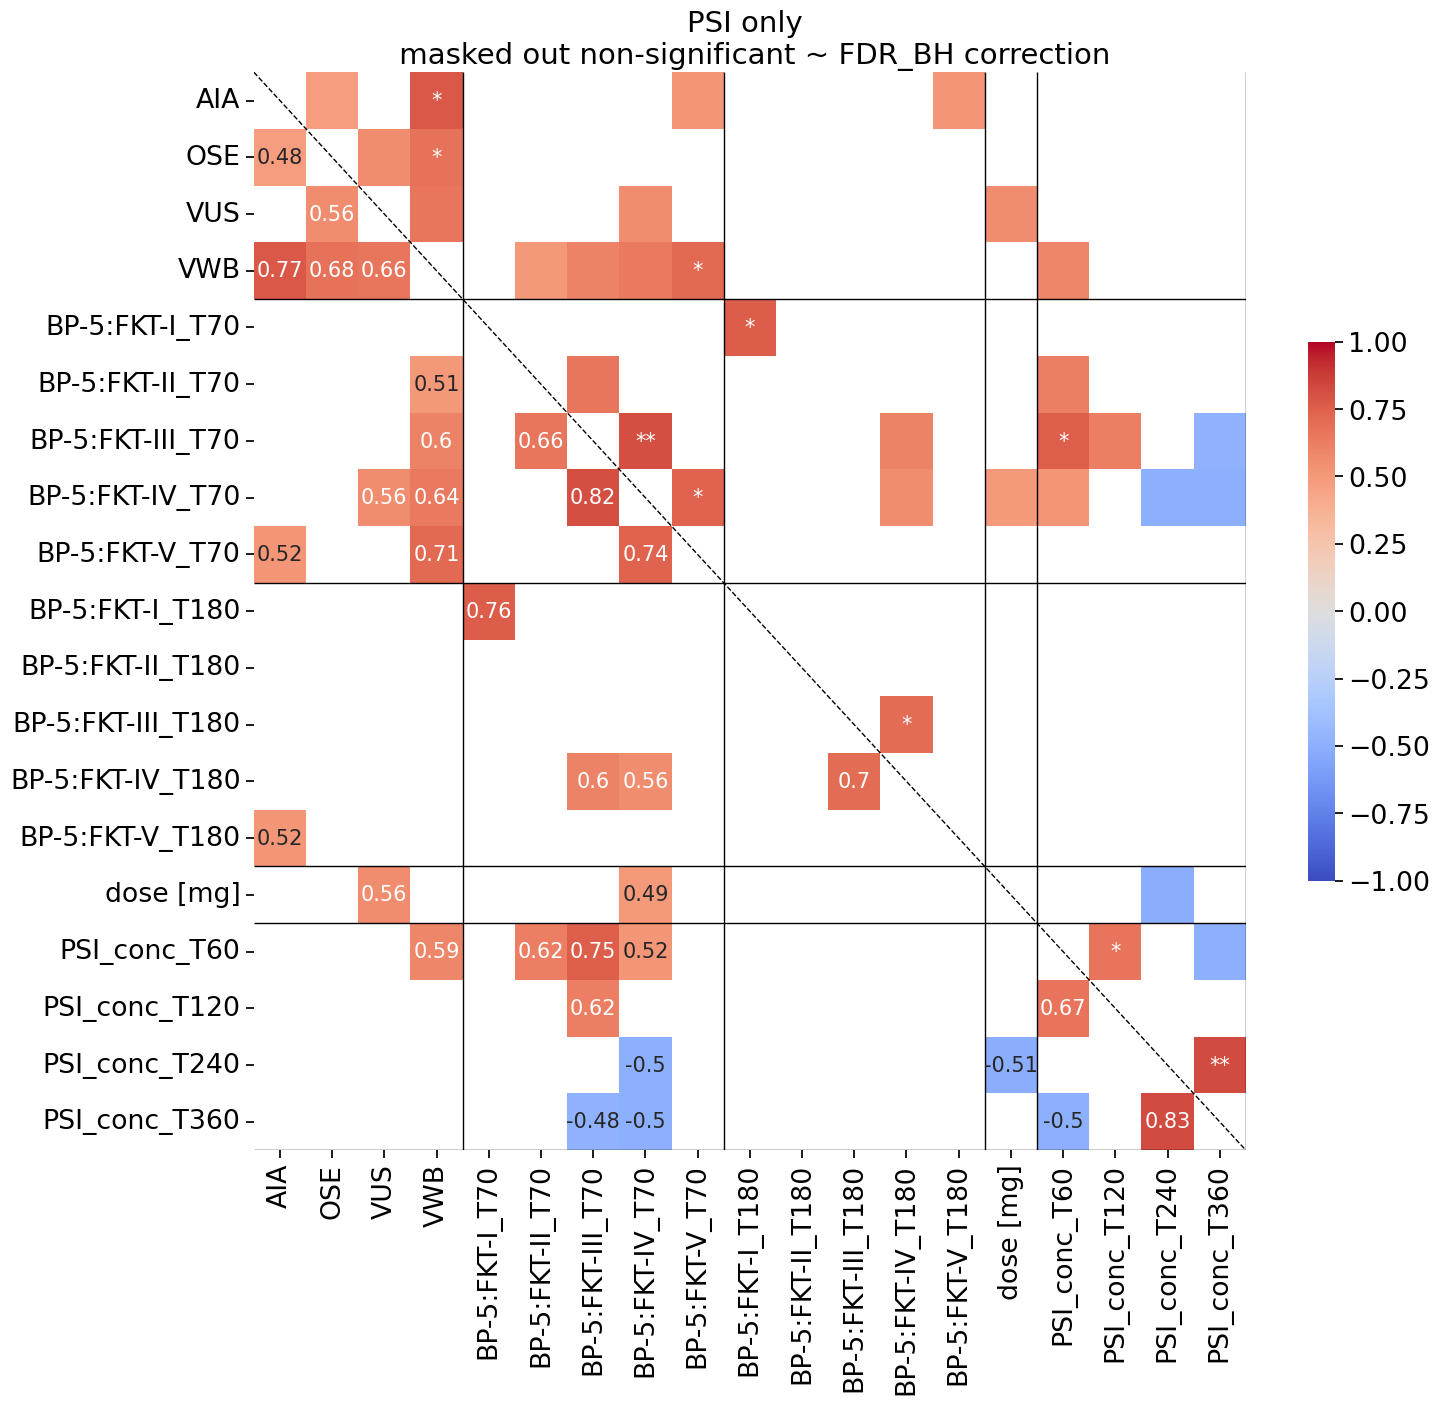

In [8]:
# only pval <= 0.05 unmasked
corr_df = (
    experience[experience["condition"] == "PSI"]
    .drop("subject", axis=1)
    .drop(
        list(experience.filter(regex="BP.*T0").columns) + ["PSI_conc_T0"],
        axis=1,
    )
)
plot_corr(
    corr_df,
    title=f"PSI only \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
    mask_upper=False,
    mask_pval=True,
    lines=[4, 9, 14, 15, 19, 20],
    method="spearman",
    fname="experience_PSIonly",
)

### Both psilocybin and placebo conditions

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:39: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(x, y)[1]
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pingouin/correlation.py:1095: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  mat_upper = self.corr(method=lambda x, y: spearmanr(x, y)[1], numeric_only=True)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(replace_pval)


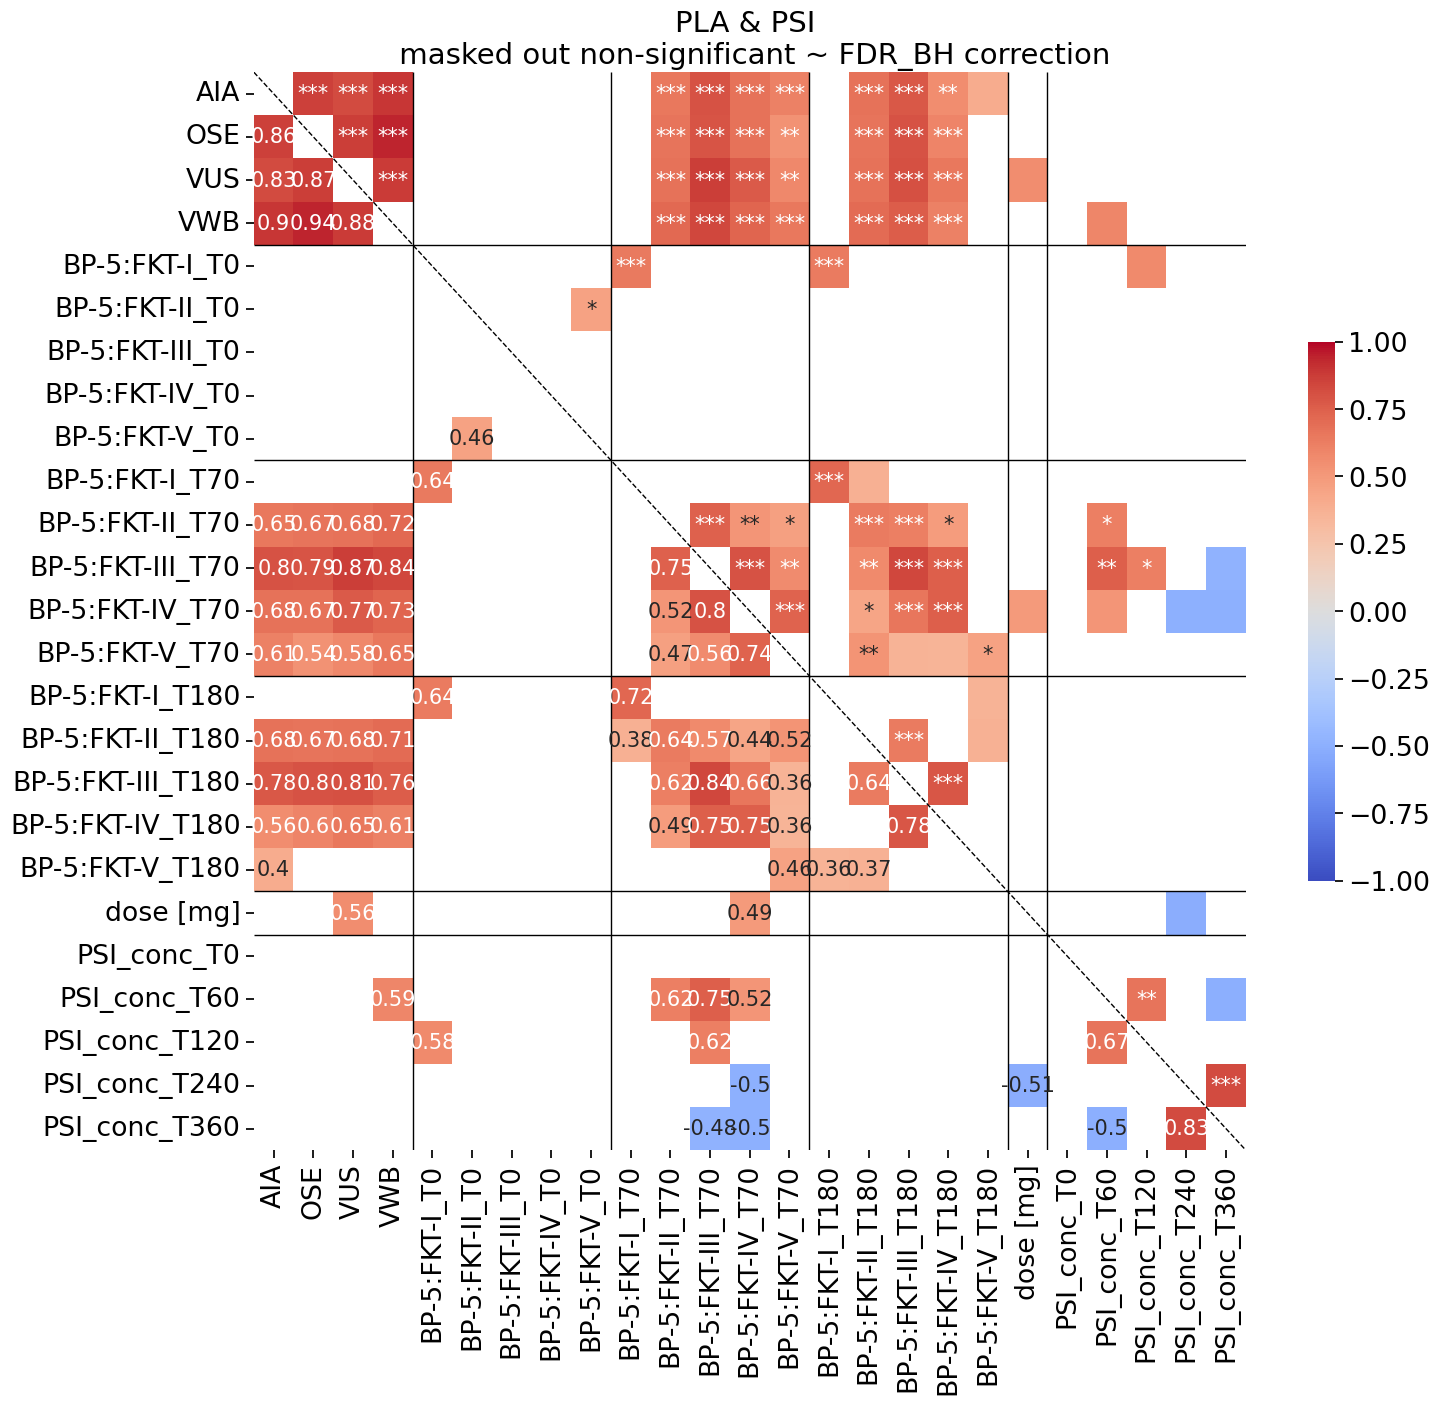

In [9]:
# only pval <= 0.05 unmasked
plot_corr(
    experience.drop("subject", axis=1),
    title=f"PLA & PSI \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
    mask_upper=False,
    mask_pval=True,
    lines=[4, 9, 14, 19, 20],
    method="spearman",
    fname="experience_PLAandPSI",
)

## Correlations with ASC questionnaire

In [10]:
ASC = ["AIA", "OSE", "VUS", "VWB"]

experience_asc = experience[["subject", "condition"] + ASC]
# match subjects
experience_asc = experience_asc.loc[
    experience_asc["subject"].isin(ms_stats["subject"])
]

In [11]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats["time"]):
    for ms in np.unique(ms_stats["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            asc_corrs = pd.concat(
                [
                    ms_stats[
                        (ms_stats["condition"] == "PSI")
                        & (ms_stats["microstate"] == ms)
                        & (ms_stats["time"] == time)
                    ]
                    .drop(ms_stats.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        experience_asc[
                            experience_asc["condition"] == "PSI"
                        ].set_index("subject")[asc],
                        method=method,
                        numeric_only=True,
                    )
                    for asc in ASC
                ],
                axis=1,
            )
            asc_corrs.columns = ASC
            asc_corrs["microstate"] = ms
            asc_corrs["time"] = time
            asc_corrs = asc_corrs.dropna(axis=1)
            asc_corrs.index = asc_corrs.index.rename("stat")
            asc_corrs = asc_corrs.set_index(
                ["time", "microstate", asc_corrs.index]
            )
            if method == "spearman":
                grand = pd.concat([grand, asc_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, asc_corrs], axis=0)

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/3586671084.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).applymap(replace_pval)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/3586671084.py:47: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = grand_pvals.applymap(


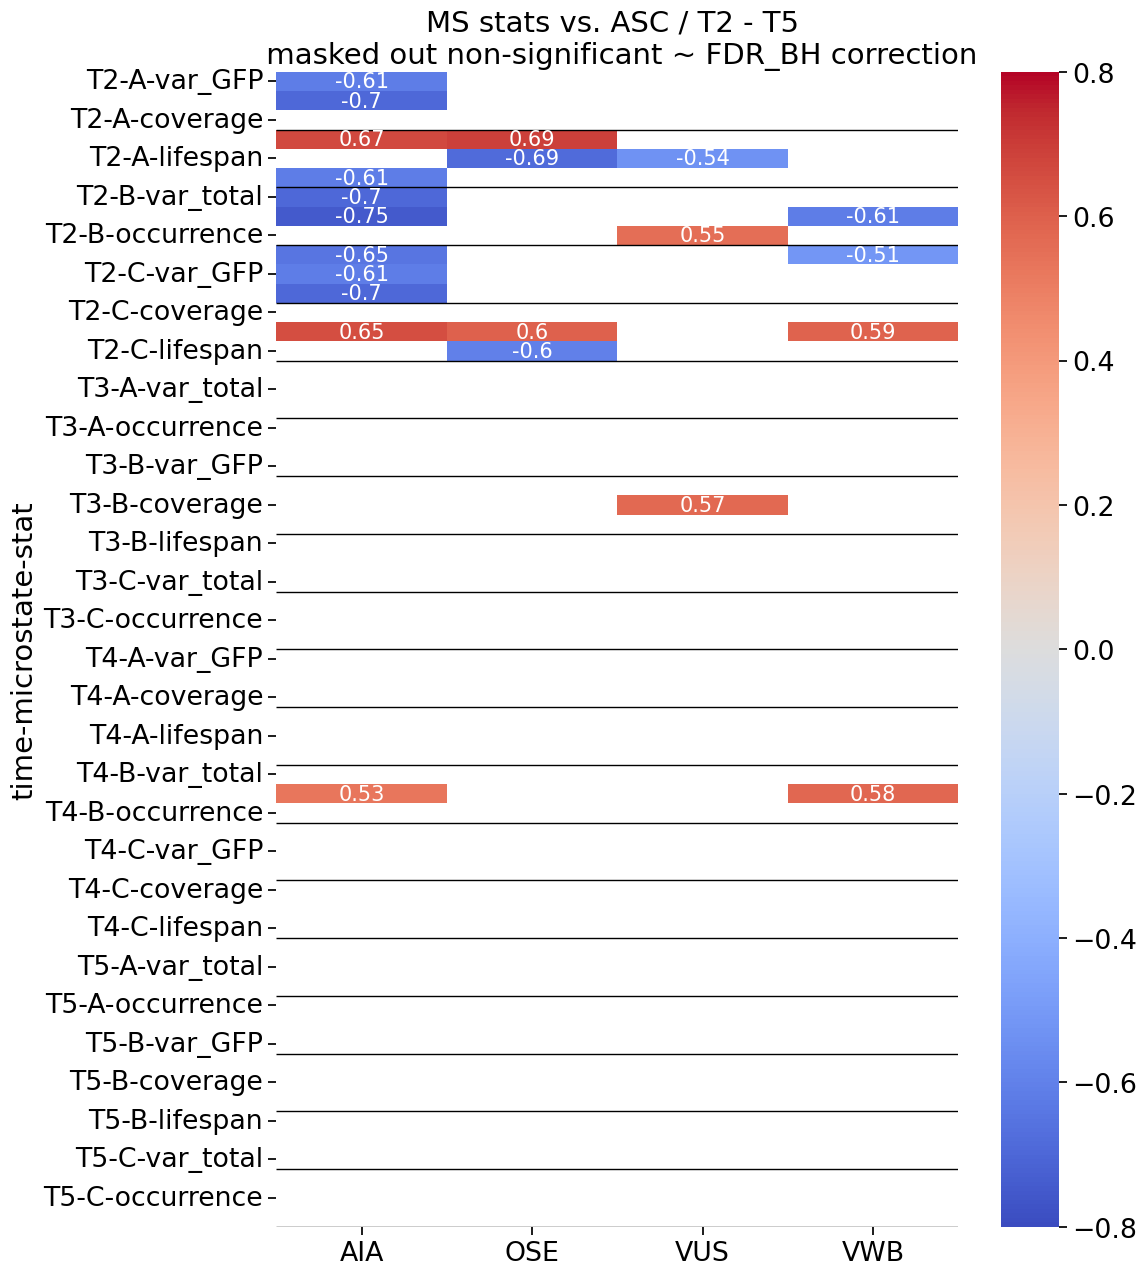

In [12]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[
        grand_pvals.index.get_level_values("time").isin(plot_times)
    ].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)
sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)]
    > 0.05,
    annot_kws={"size": 15},
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines(
    [], *plt.gca().get_ylim(), color=plt.rcParams["text.color"], linewidth=1.0
)
plt.title(
    f"MS stats vs. ASC / T2 - T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_ASC_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.001, 0.01, 0.05] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(
            WORKING_DIR, "MSstats_w_ASC_1-40filt_spearman_correlation.csv"
        )
    )

## Correlations with BPRS questionnaire

In [13]:
BP = list(experience.filter(like="BP").columns)

experience_bprs = experience[["subject", "condition"] + BP]
# match subjects
experience_bprs = experience_bprs.loc[
    experience_bprs["subject"].isin(ms_stats["subject"])
]

In [14]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats["time"]):
    for ms in np.unique(ms_stats["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            bprs_corrs = pd.concat(
                [
                    ms_stats[
                        (ms_stats["condition"] == "PSI")
                        & (ms_stats["microstate"] == ms)
                        & (ms_stats["time"] == time)
                    ]
                    .drop(ms_stats.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        experience_bprs[
                            experience_bprs["condition"] == "PSI"
                        ].set_index("subject")[bprs],
                        method=method,
                        numeric_only=True,
                    )
                    for bprs in BP
                ],
                axis=1,
            )
            bprs_corrs.columns = BP
            bprs_corrs["microstate"] = ms
            bprs_corrs["time"] = time
            bprs_corrs = bprs_corrs.dropna(axis=1)
            bprs_corrs.index = bprs_corrs.index.rename("stat")
            bprs_corrs = bprs_corrs.set_index(
                ["time", "microstate", bprs_corrs.index]
            )
            if method == "spearman":
                grand = pd.concat([grand, bprs_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, bprs_corrs], axis=0)

/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/3948104068.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/3948104068.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
/Users/nikola/work-brain/psilocybin-microstate

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1517661057.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).applymap(replace_pval)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1517661057.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = grand_pvals.applymap(


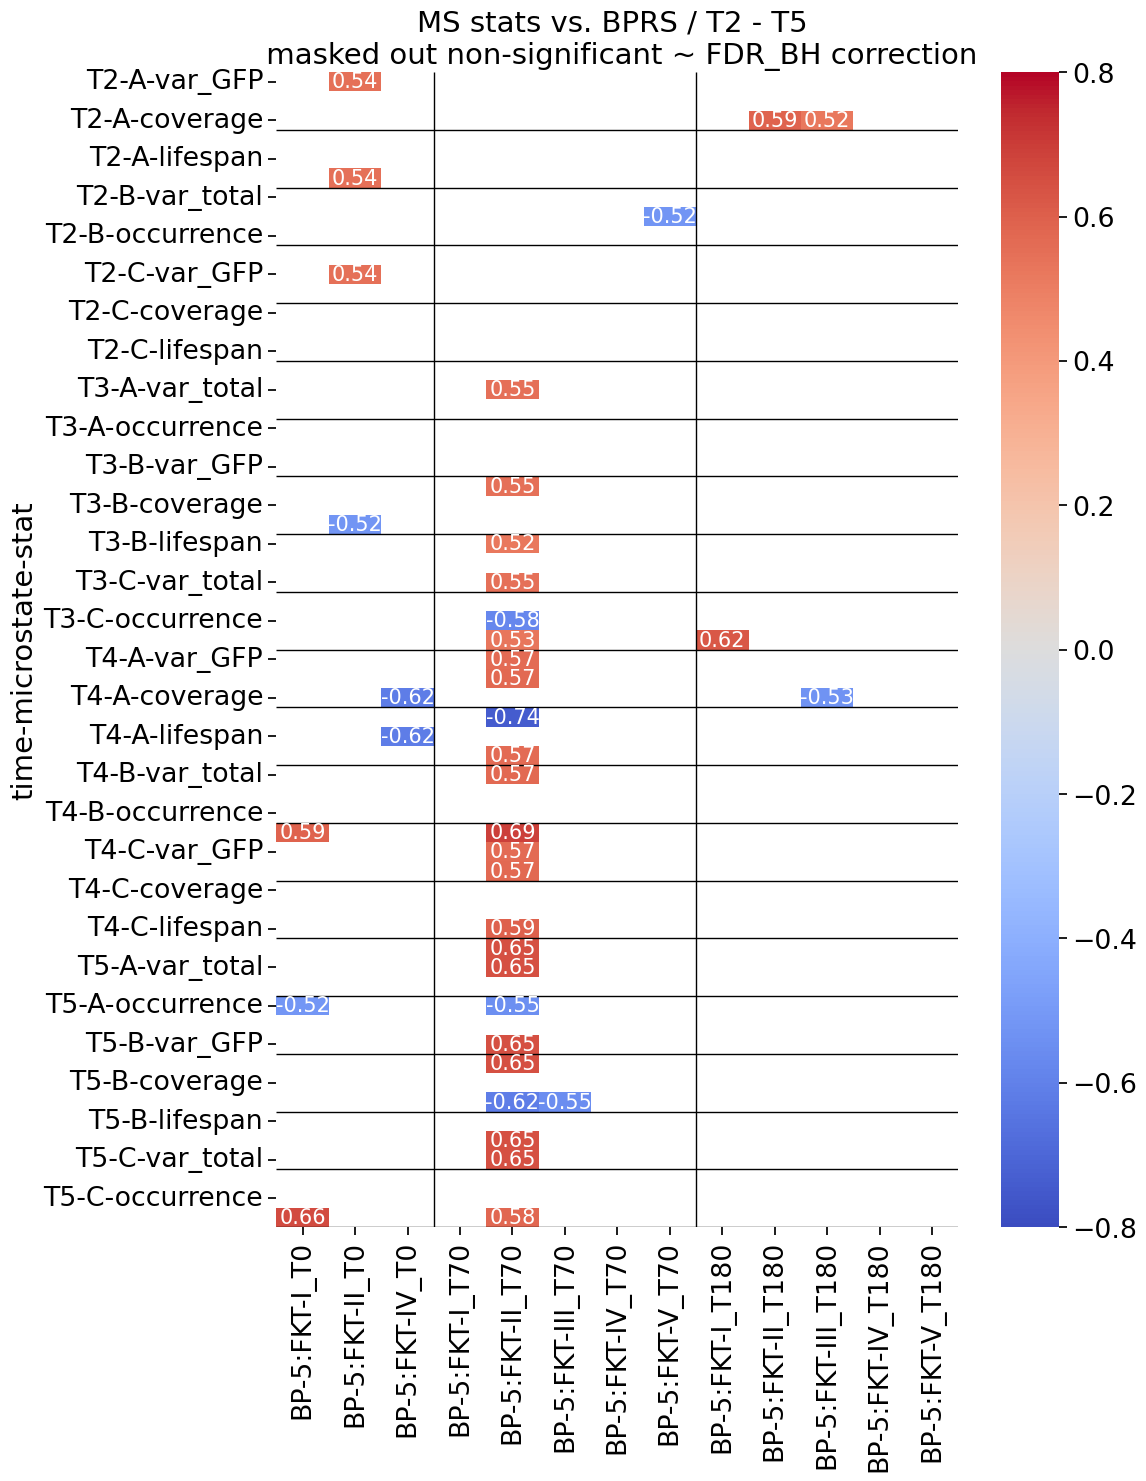

In [15]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[
        grand_pvals.index.get_level_values("time").isin(plot_times)
    ].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)

sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)]
    > 0.05,
    annot_kws={"size": 15},
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines(
    [3, 8],
    *plt.gca().get_ylim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.title(
    f"MS stats vs. BPRS / T2 - T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_BPRS_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.001, 0.01, 0.05] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(
            WORKING_DIR, "MSstats_w_BPRS_1-40filt_spearman_correlation.csv"
        )
    )

## Correlations with dosage

In [16]:
CONC = list(experience.filter(like="conc").columns) + ["dose [mg]"]

experience_conc = experience[["subject", "condition"] + CONC]
# match subjects
experience_conc = experience_conc.loc[
    experience_conc["subject"].isin(ms_stats["subject"])
]

In [17]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats["time"]):
    for ms in np.unique(ms_stats["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            conc_corrs = pd.concat(
                [
                    ms_stats[
                        (ms_stats["condition"] == "PSI")
                        & (ms_stats["microstate"] == ms)
                        & (ms_stats["time"] == time)
                    ]
                    .drop(ms_stats.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        experience_conc[
                            experience_conc["condition"] == "PSI"
                        ].set_index("subject")[conc],
                        method=method,
                        numeric_only=True,
                    )
                    for conc in CONC
                ],
                axis=1,
            )
            conc_corrs.columns = CONC
            conc_corrs["microstate"] = ms
            conc_corrs["time"] = time
            conc_corrs = conc_corrs.dropna(axis=1)
            conc_corrs.index = conc_corrs.index.rename("stat")
            conc_corrs = conc_corrs.set_index(
                ["time", "microstate", conc_corrs.index]
            )
            if method == "spearman":
                grand = pd.concat([grand, conc_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, conc_corrs], axis=0)

/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2591864337.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2591864337.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
/Users/nikola/work-brain/psilocybin-microstate

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/3104442012.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).applymap(replace_pval)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/3104442012.py:48: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = grand_pvals.applymap(


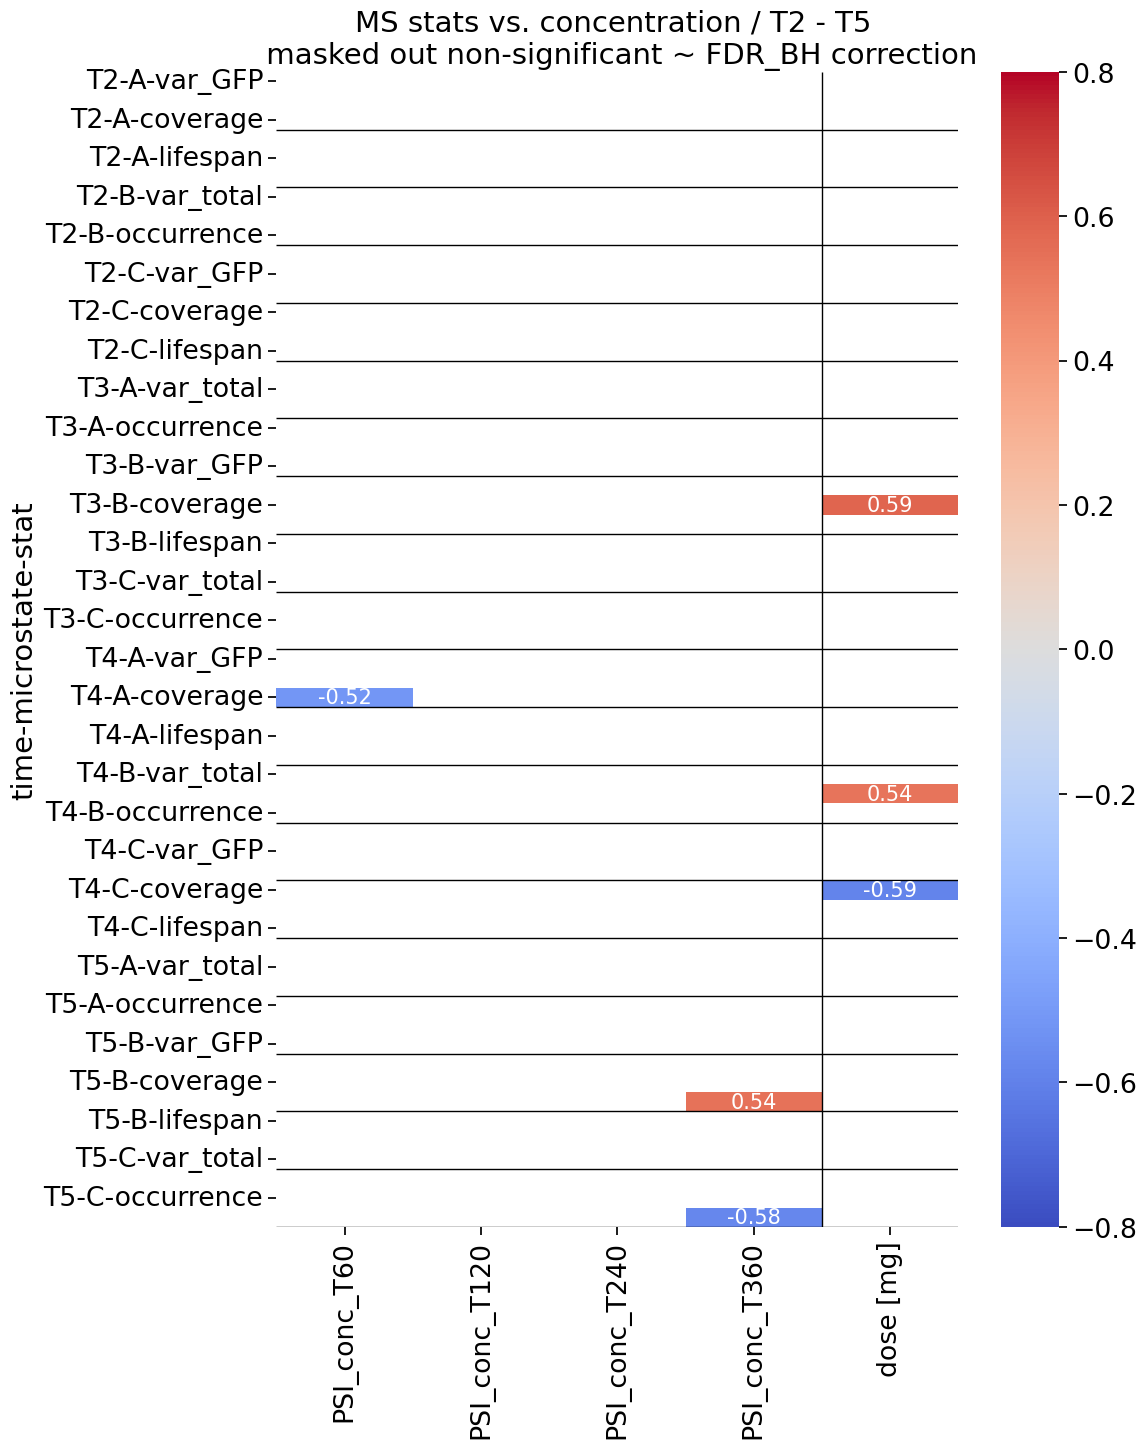

In [18]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[
        grand_pvals.index.get_level_values("time").isin(plot_times)
    ].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)

sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)]
    > 0.05,
    annot_kws={"size": 15},
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines(
    [4], *plt.gca().get_ylim(), color=plt.rcParams["text.color"], linewidth=1.0
)
plt.title(
    f"MS stats vs. concentration / T2 - T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_conc_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.001, 0.01, 0.05] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(
            WORKING_DIR, "MSstats_w_conc_1-40filt_spearman_correlation.csv"
        )
    )

## Correlations with persistent effects

In [19]:
# match subjects
persisting = persisting_effs.drop("order", axis=1).loc[
    persisting_effs["subject"].isin(ms_stats["subject"])
]
EFFECTS = list(persisting.columns[2:])

In [20]:
grand = pd.DataFrame([])
grand_pvals = pd.DataFrame([])
for time in np.unique(ms_stats["time"]):
    for ms in np.unique(ms_stats["microstate"]):
        for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
            pers_corrs = pd.concat(
                [
                    ms_stats[
                        (ms_stats["condition"] == "PSI")
                        & (ms_stats["microstate"] == ms)
                        & (ms_stats["time"] == time)
                    ]
                    .drop(ms_stats.filter(regex="transition"), axis=1)
                    .set_index("subject")
                    .corrwith(
                        persisting[persisting["condition"] == "PSI"].set_index(
                            "subject"
                        )[eff],
                        method=method,
                        numeric_only=True,
                    )
                    for eff in EFFECTS
                ],
                axis=1,
            )
            pers_corrs.columns = EFFECTS
            pers_corrs["microstate"] = ms
            pers_corrs["time"] = time
            pers_corrs = pers_corrs.dropna(axis=1)
            pers_corrs.index = pers_corrs.index.rename("stat")
            pers_corrs = pers_corrs.set_index(
                ["time", "microstate", pers_corrs.index]
            )
            if method == "spearman":
                grand = pd.concat([grand, pers_corrs], axis=0)
            else:
                grand_pvals = pd.concat([grand_pvals, pers_corrs], axis=0)

/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/3013116504.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
/Users/nikola/work-brain/psilocybin-microstates/code/.venv/lib/python3.12/site-packages/pandas/core/nanops.py:1632: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  return spearmanr(a, b)[0]
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/3013116504.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  for method in ["spearman", lambda x, y: spearmanr(x, y)[1]]:
/Users/nikola/work-brain/psilocybin-microstate

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/425203482.py:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  ).applymap(replace_pval)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/425203482.py:51: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = grand_pvals.applymap(


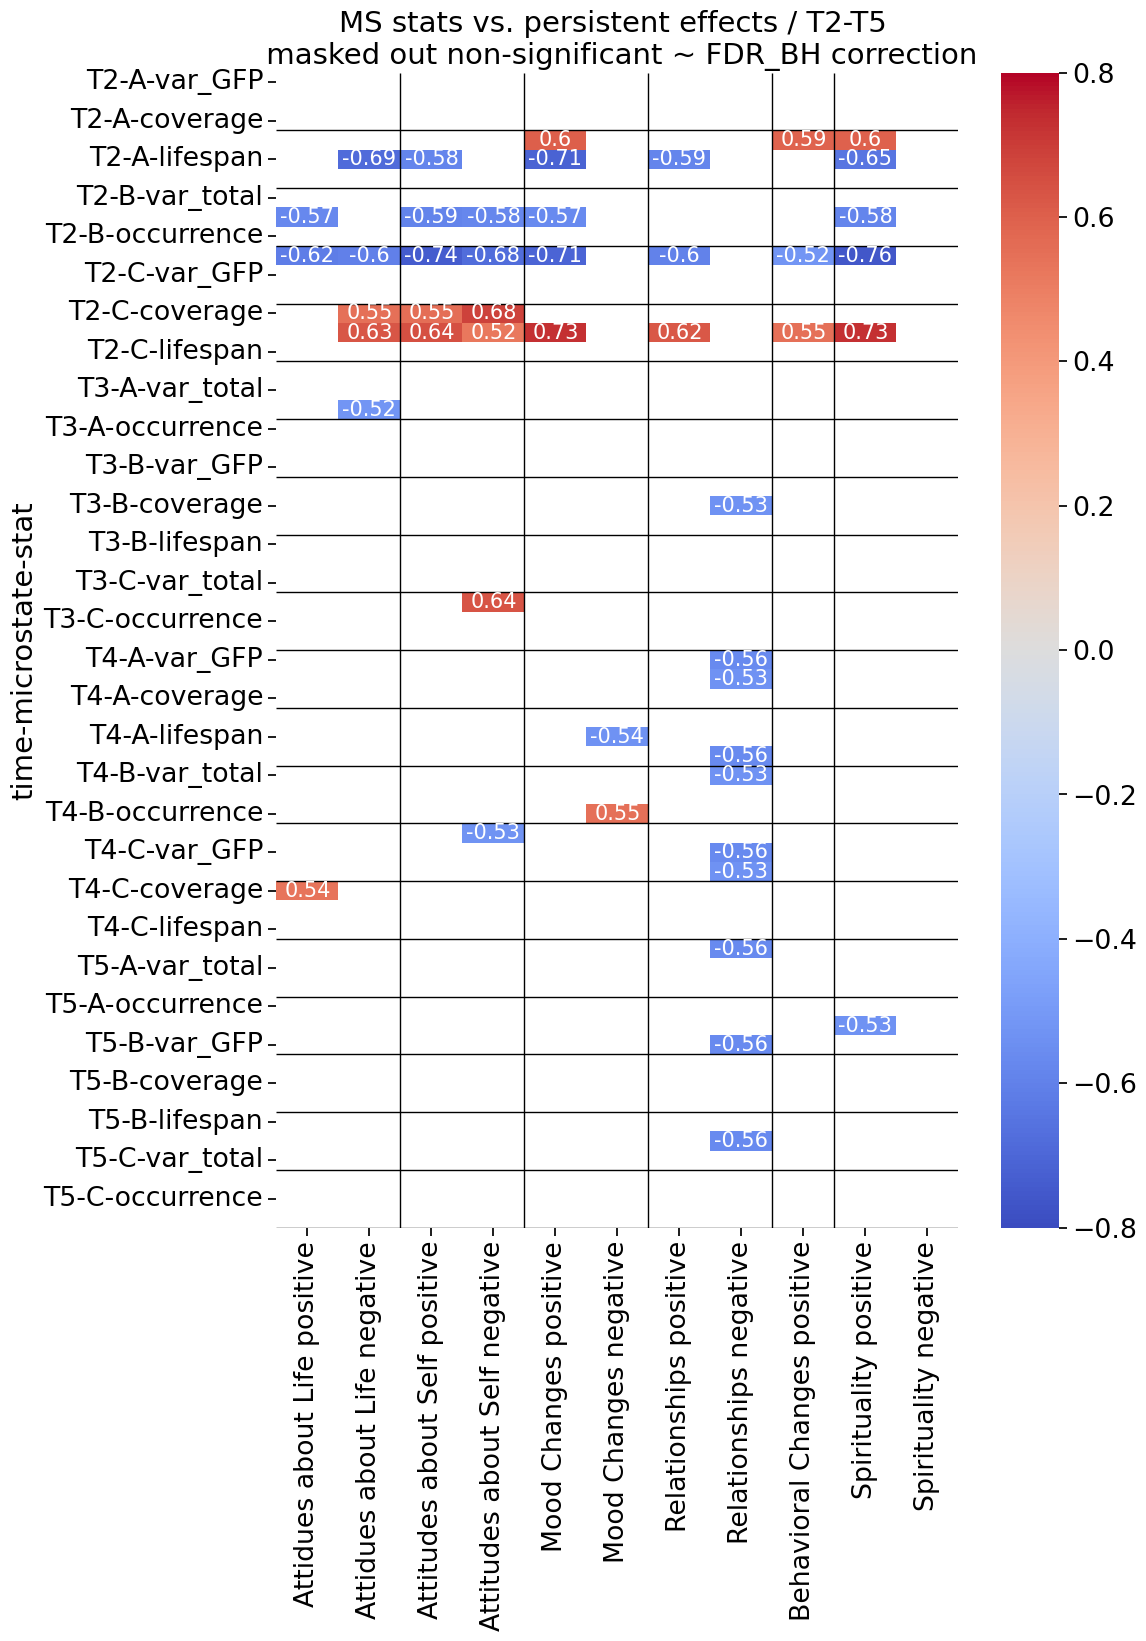

In [21]:
plot_times = ["T2", "T3", "T4", "T5"]

plt.figure(figsize=(11, 15))
plot_df = grand[grand.index.get_level_values("time").isin(plot_times)]
_, bonf_corrd = multicomp(
    grand_pvals[
        grand_pvals.index.get_level_values("time").isin(plot_times)
    ].values,
    alpha=0.05,
    method=MULTI_CORRECTION,
)
bonf_corrd = pd.DataFrame(
    bonf_corrd, columns=plot_df.columns, index=plot_df.index
).applymap(replace_pval)

sns.heatmap(
    plot_df,
    cmap="coolwarm",
    annot=plot_df.round(2).astype(str) + bonf_corrd,
    vmin=-0.8,
    vmax=0.8,
    fmt="",
    mask=grand_pvals[grand.index.get_level_values("time").isin(plot_times)]
    > 0.05,
    annot_kws={"size": 15},
)
plt.hlines(
    np.arange(3, grand.shape[0], 3).tolist(),
    *plt.gca().get_xlim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.vlines(
    [2, 4, 6, 8, 9],
    *plt.gca().get_ylim(),
    color=plt.rcParams["text.color"],
    linewidth=1.0,
)
plt.title(
    f"MS stats vs. persistent effects / T2-T5 \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction"
)
if SAVE_RESULTS:
    plt.savefig(
        os.path.join(
            PLOTTING_DIR,
            f"MSstats_w_persistent_effects_T2-T5_1-40filt_spearman_correlation{PLOT_EXT}",
        ),
        bbox_inches="tight",
        transparent=True,
    )
    p = grand_pvals.applymap(
        lambda x: "".join(["*" for t in [0.001, 0.01, 0.05] if x <= t])
    )
    corr = grand.round(5).astype(str) + p
    corr.to_csv(
        os.path.join(
            WORKING_DIR,
            "MSstats_w_persistent_effects_1-40filt_spearman_correlation.csv",
        )
    )

In [22]:
# group data in experience data
experience_grp = experience[experience["condition"] == "PSI"].loc[
    experience["subject"].isin(ms_stats["subject"])
]
experience_grp = experience_grp.drop(["order", "usage time"], axis=1).set_index(
    ["subject", "condition"]
)
groupings = {
    "ASC": ASC,
    "BPRS_T70": list(experience_grp.filter(like="T70").columns),
    "BPRS_T180": list(experience_grp.filter(like="T180").columns),
}

for key, val in groupings.items():
    experience_grp = pd.concat(
        [experience_grp, pd_pca(experience_grp[val], 1, key)], axis=1
    ).drop(val, axis=1)
experience_grp = experience_grp.drop(
    list(experience_grp.filter(like="T0").columns), axis=1
)
experience_grp.index = experience_grp.index.droplevel("condition")

In [23]:
persisting_effs_grp = persisting_effs[
    persisting_effs["condition"] == "PSI"
].loc[persisting_effs["subject"].isin(ms_stats["subject"])]
persisting_effs_grp = persisting_effs_grp.drop(
    ["order", "condition"]
    + list(persisting_effs_grp.filter(like="negative").columns),
    axis=1,
).set_index("subject")

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(replace_pval)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(replace_pval)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(replace_pval)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(replace_pval)


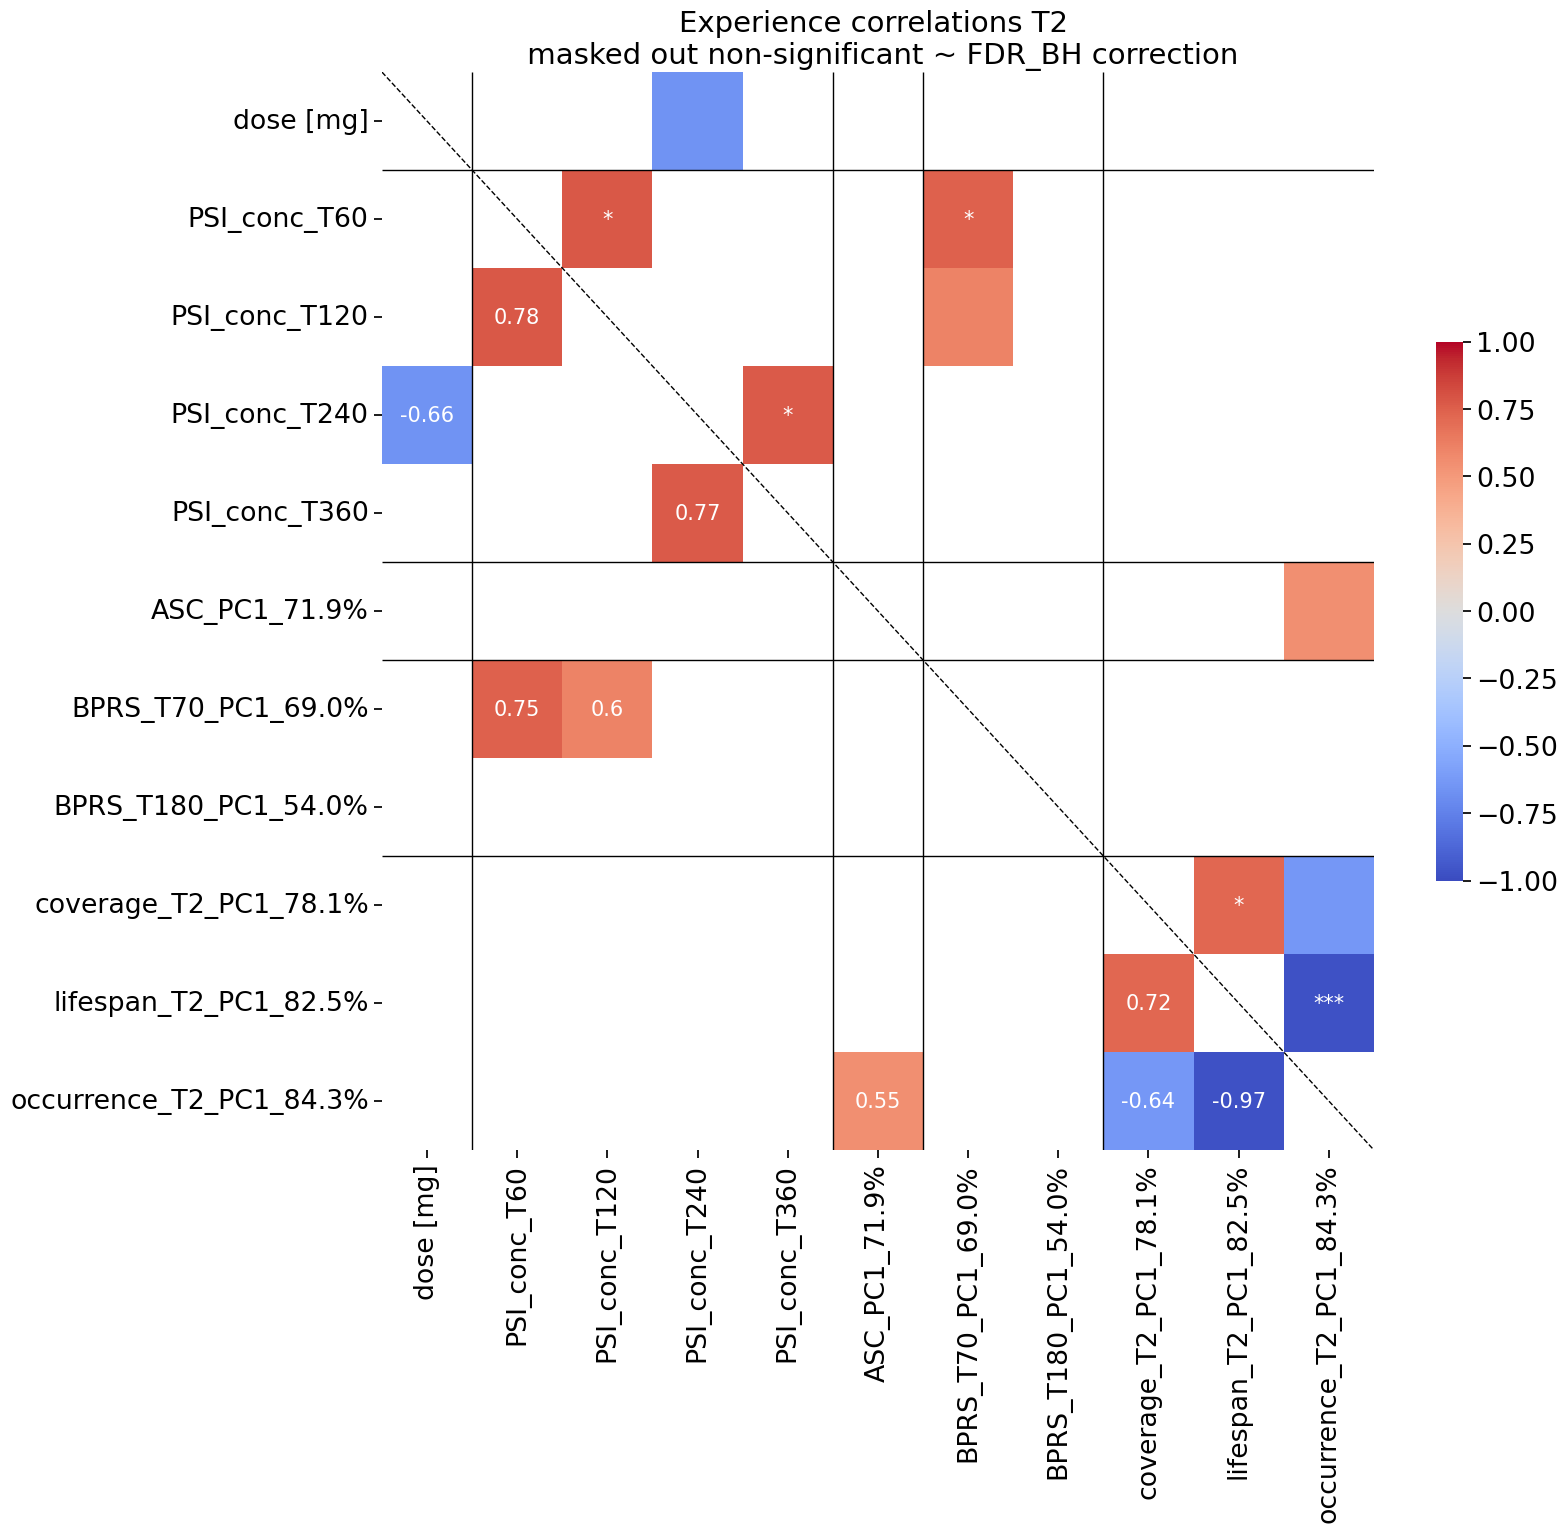

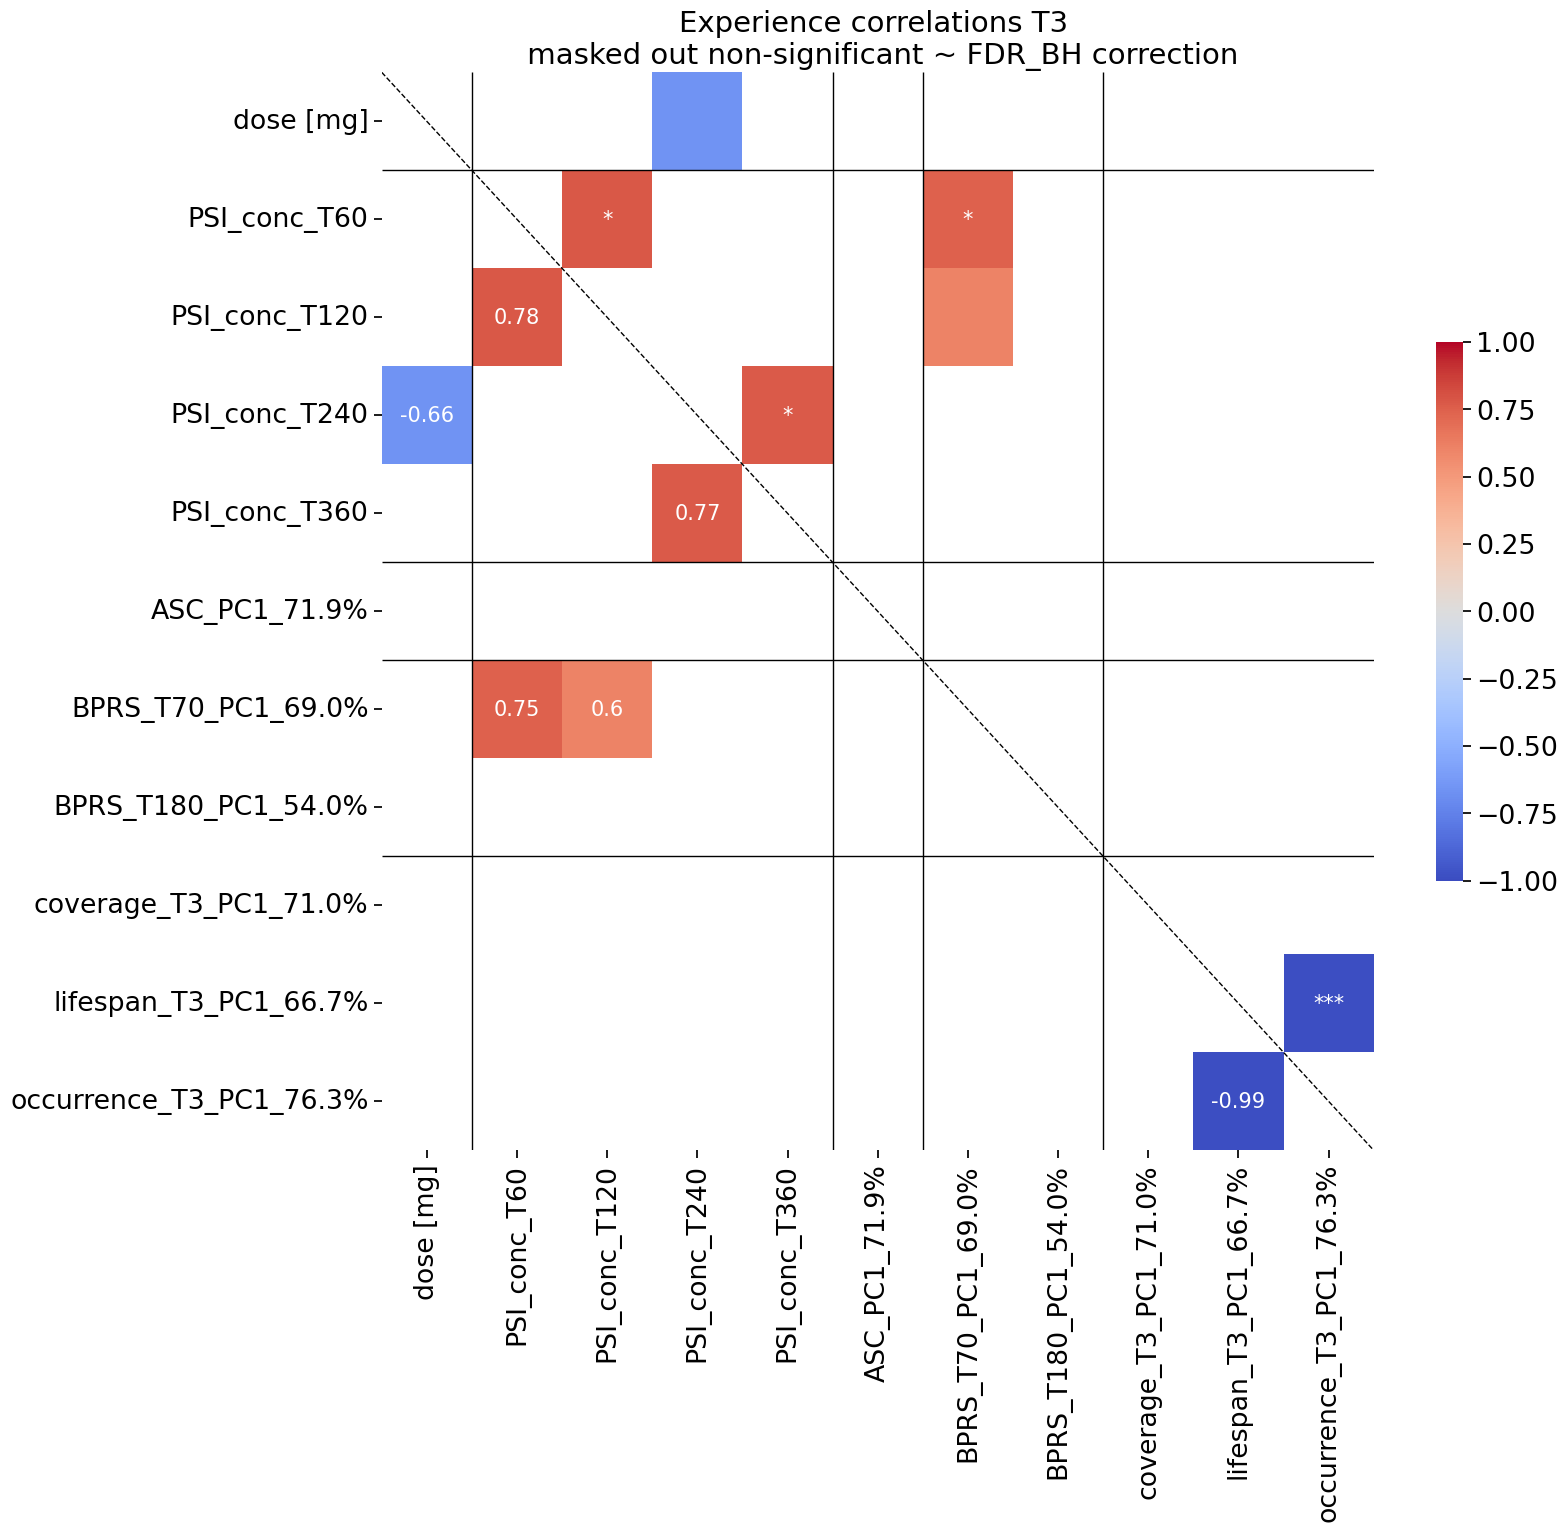

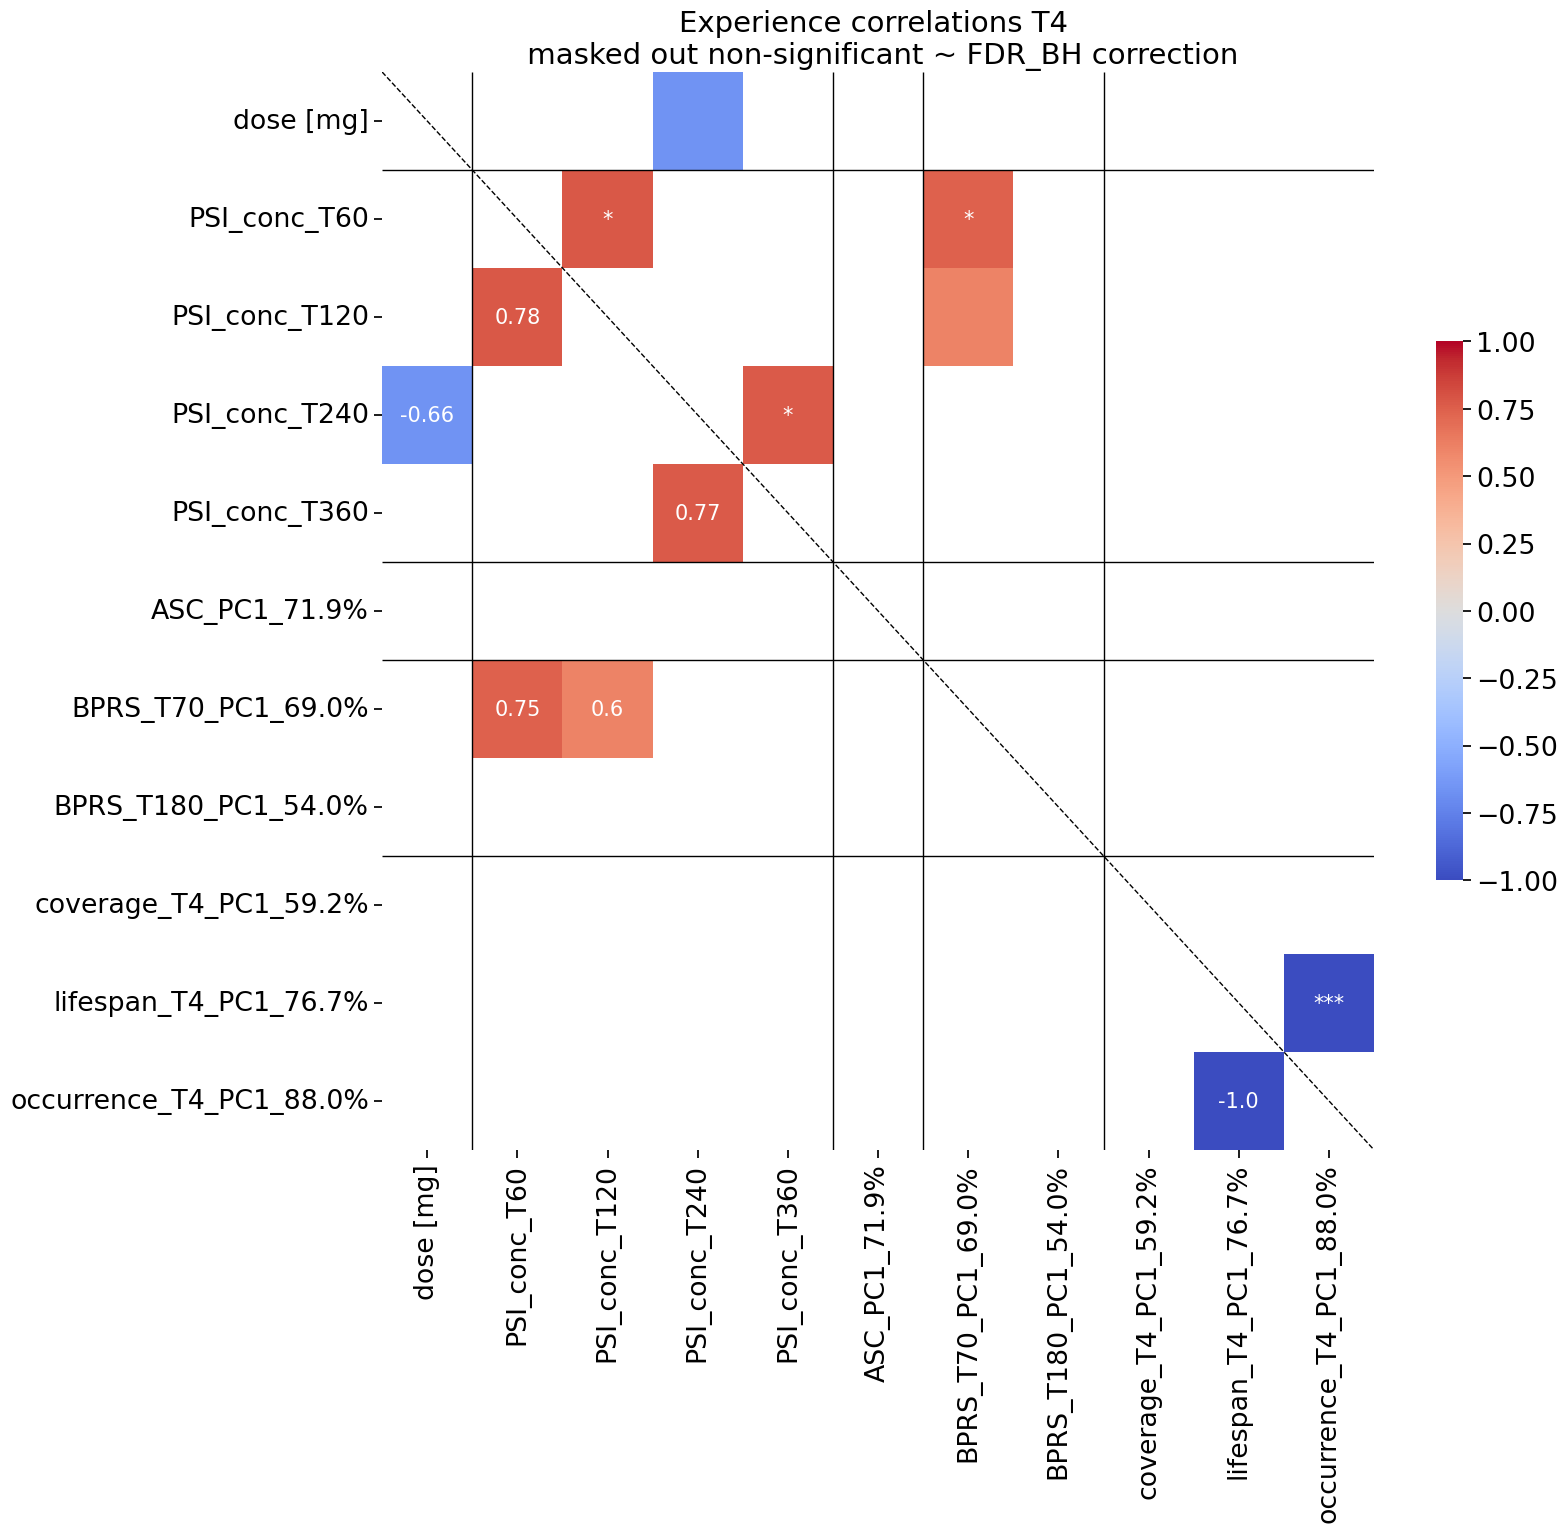

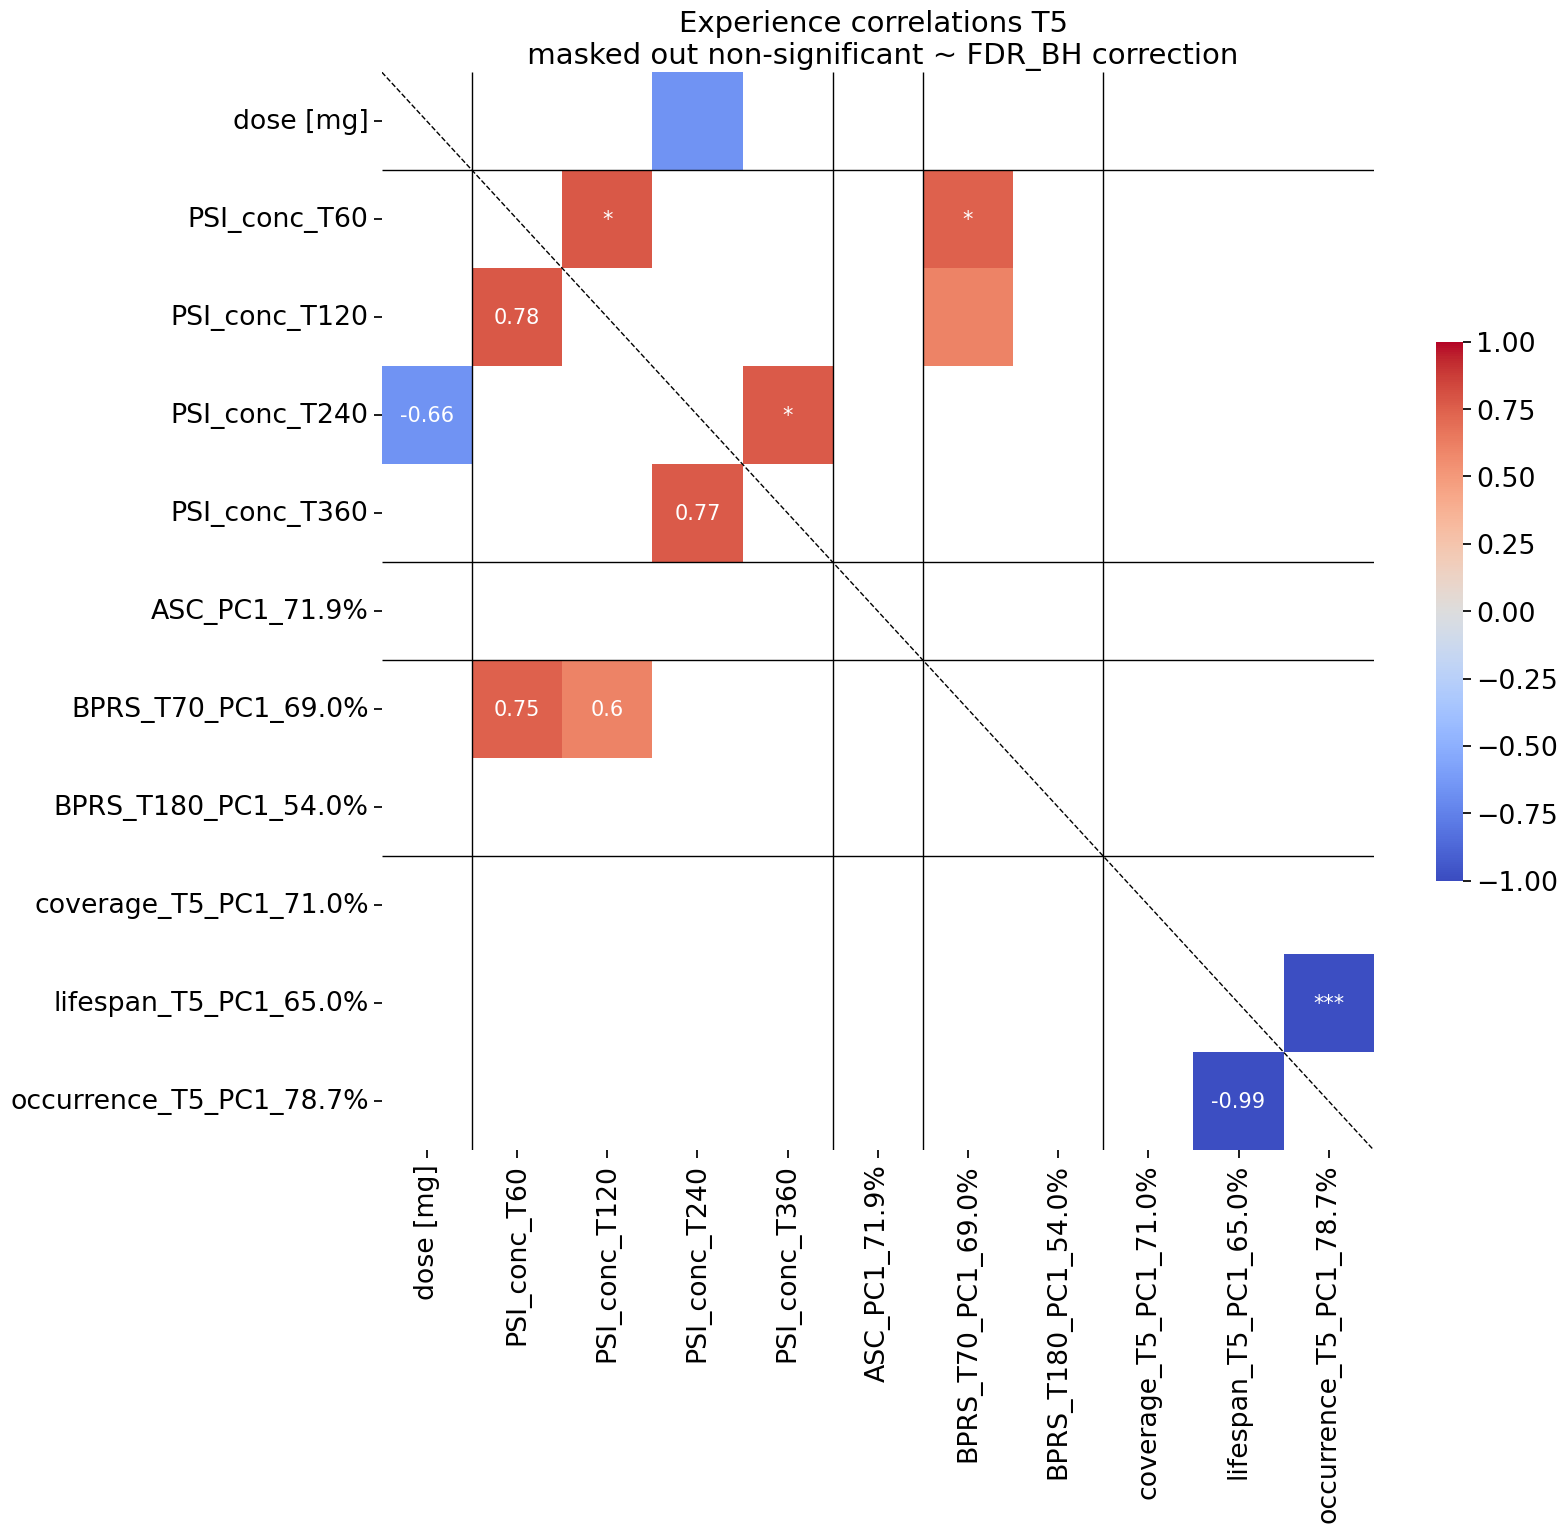

In [24]:
ms_stats_grp = (
    ms_stats[ms_stats["condition"] == "PSI"]
    .drop(["session", "ms_opts"], axis=1)
    .set_index(["subject", "condition", "time"])
)
groupings = ["coverage", "lifespan", "occurrence"]

for time in ["T2", "T3", "T4", "T5"]:
    ms_stats_grp_ = pd.DataFrame()
    for grp in groupings:
        pca_mat = pd_pca(
            ms_stats_grp[ms_stats_grp.index.get_level_values("time") == time]
            .reset_index()
            .pivot(index="subject", columns="microstate", values=grp),
            1,
            f"{grp}_{time}",
        )
        ms_stats_grp_ = pd.concat([ms_stats_grp_, pca_mat], axis=1)

    grp_corrs = pd.concat([experience_grp, ms_stats_grp_], axis=1)
    plot_corr(
        grp_corrs,
        method="spearman",
        mask_upper=False,
        mask_pval=True,
        lines=[1, 5, 6, 8],
        title=f"Experience correlations {time} \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
        fname=f"experience_agg_{time}",
    )

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(replace_pval)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(replace_pval)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(replace_pval)
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/2654754255.py:97: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  p = pval.applymap(replace_pval)


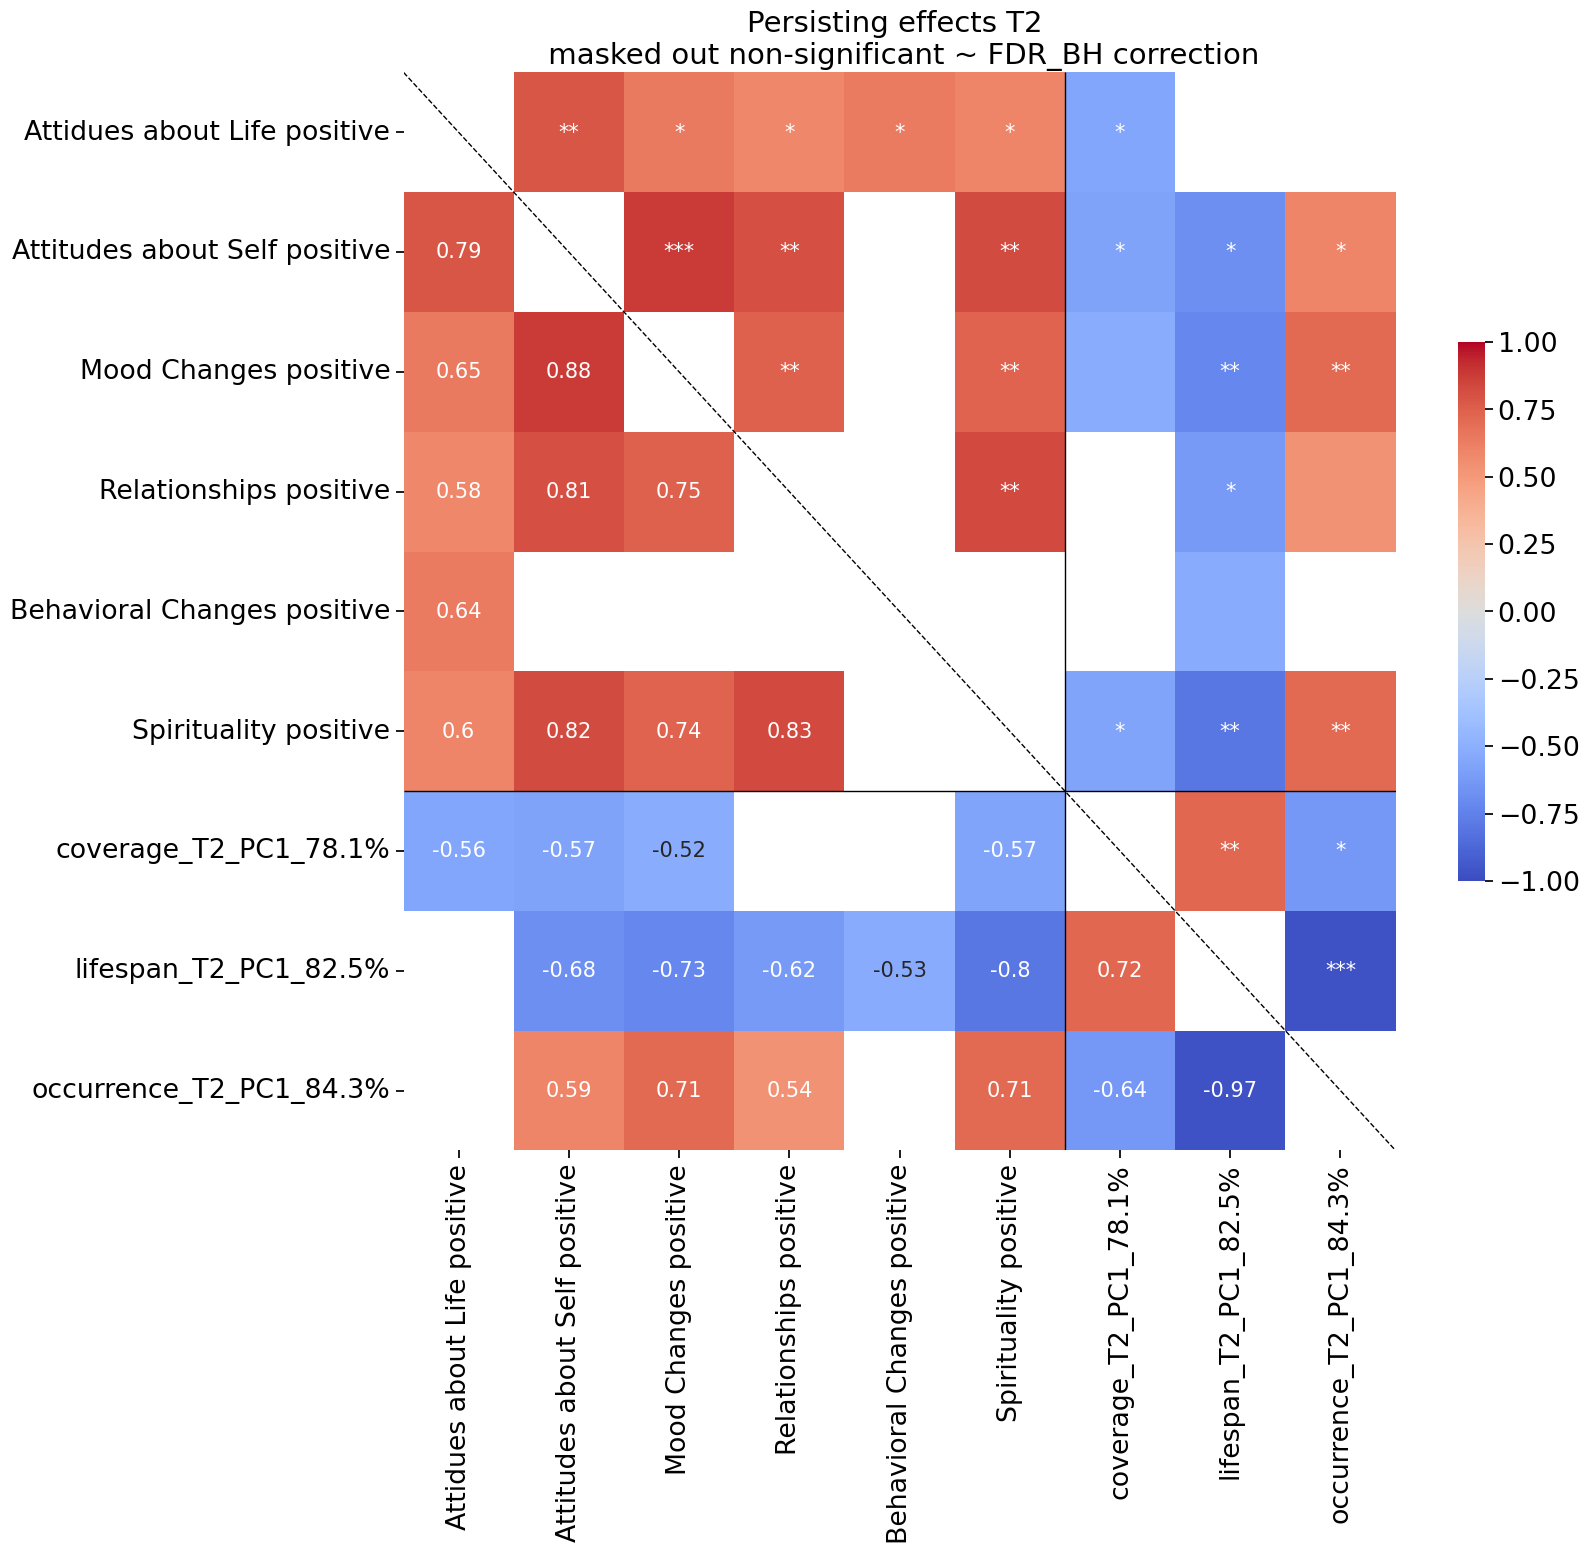

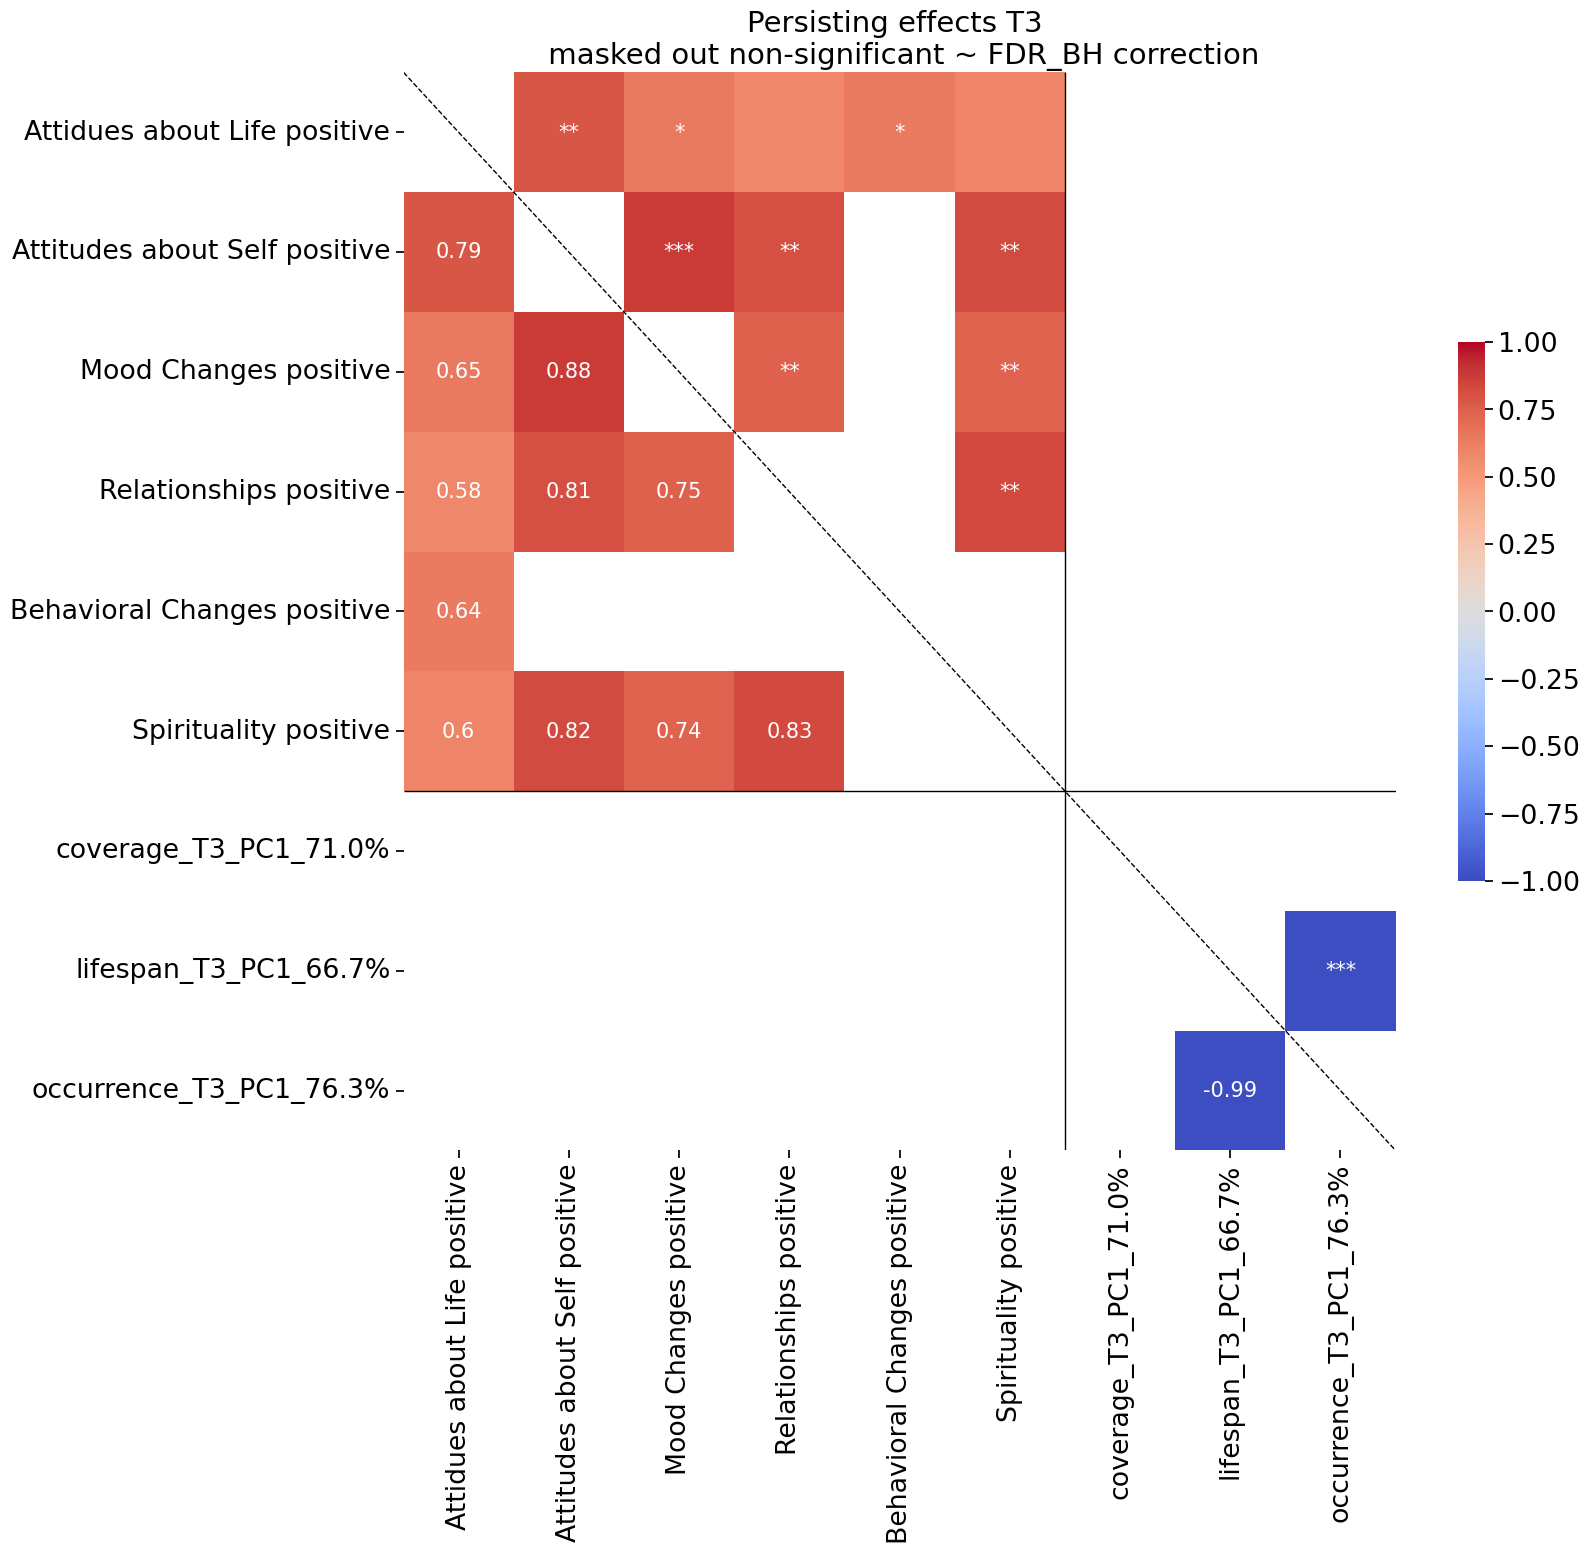

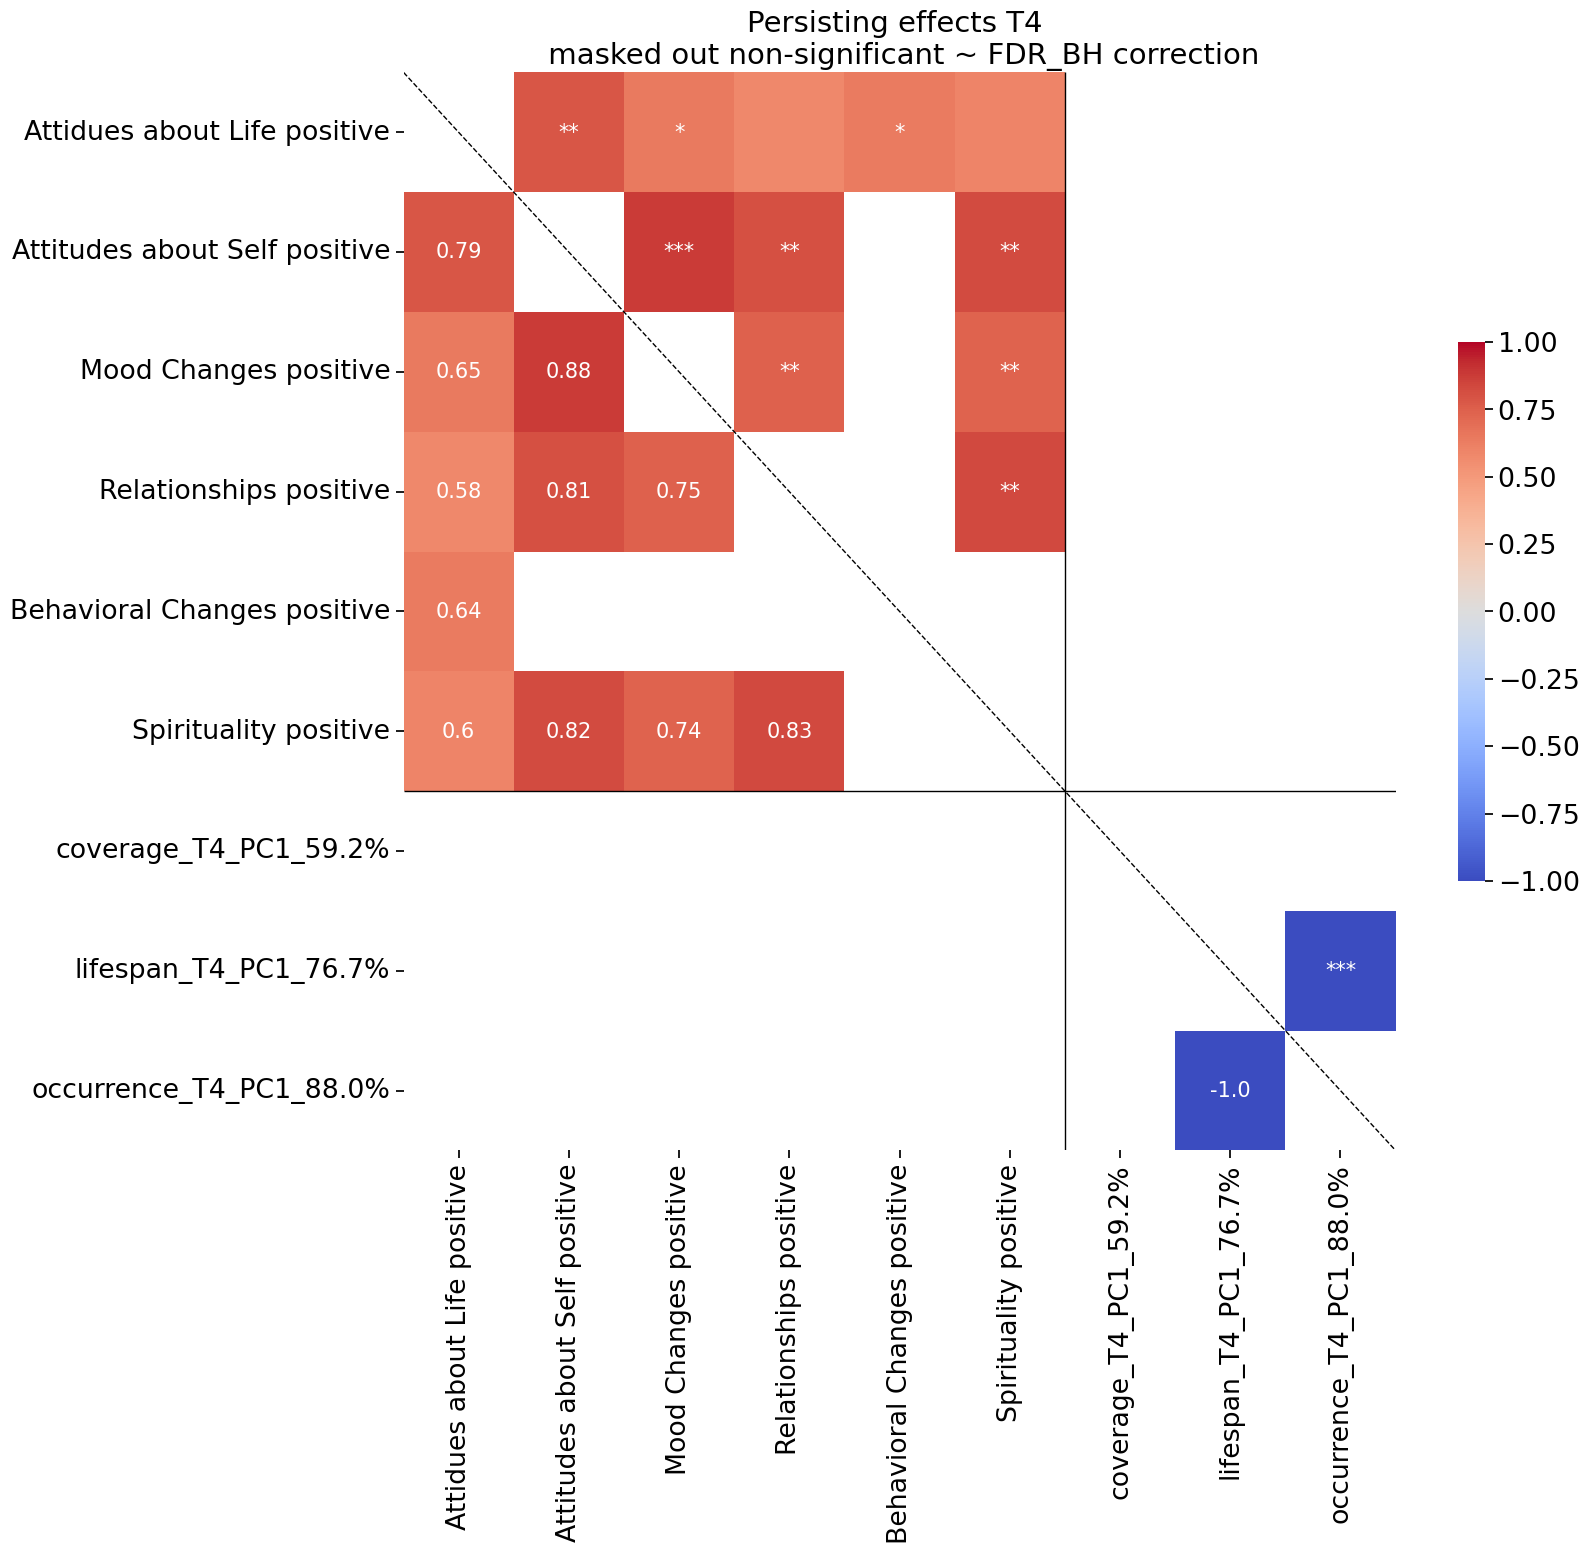

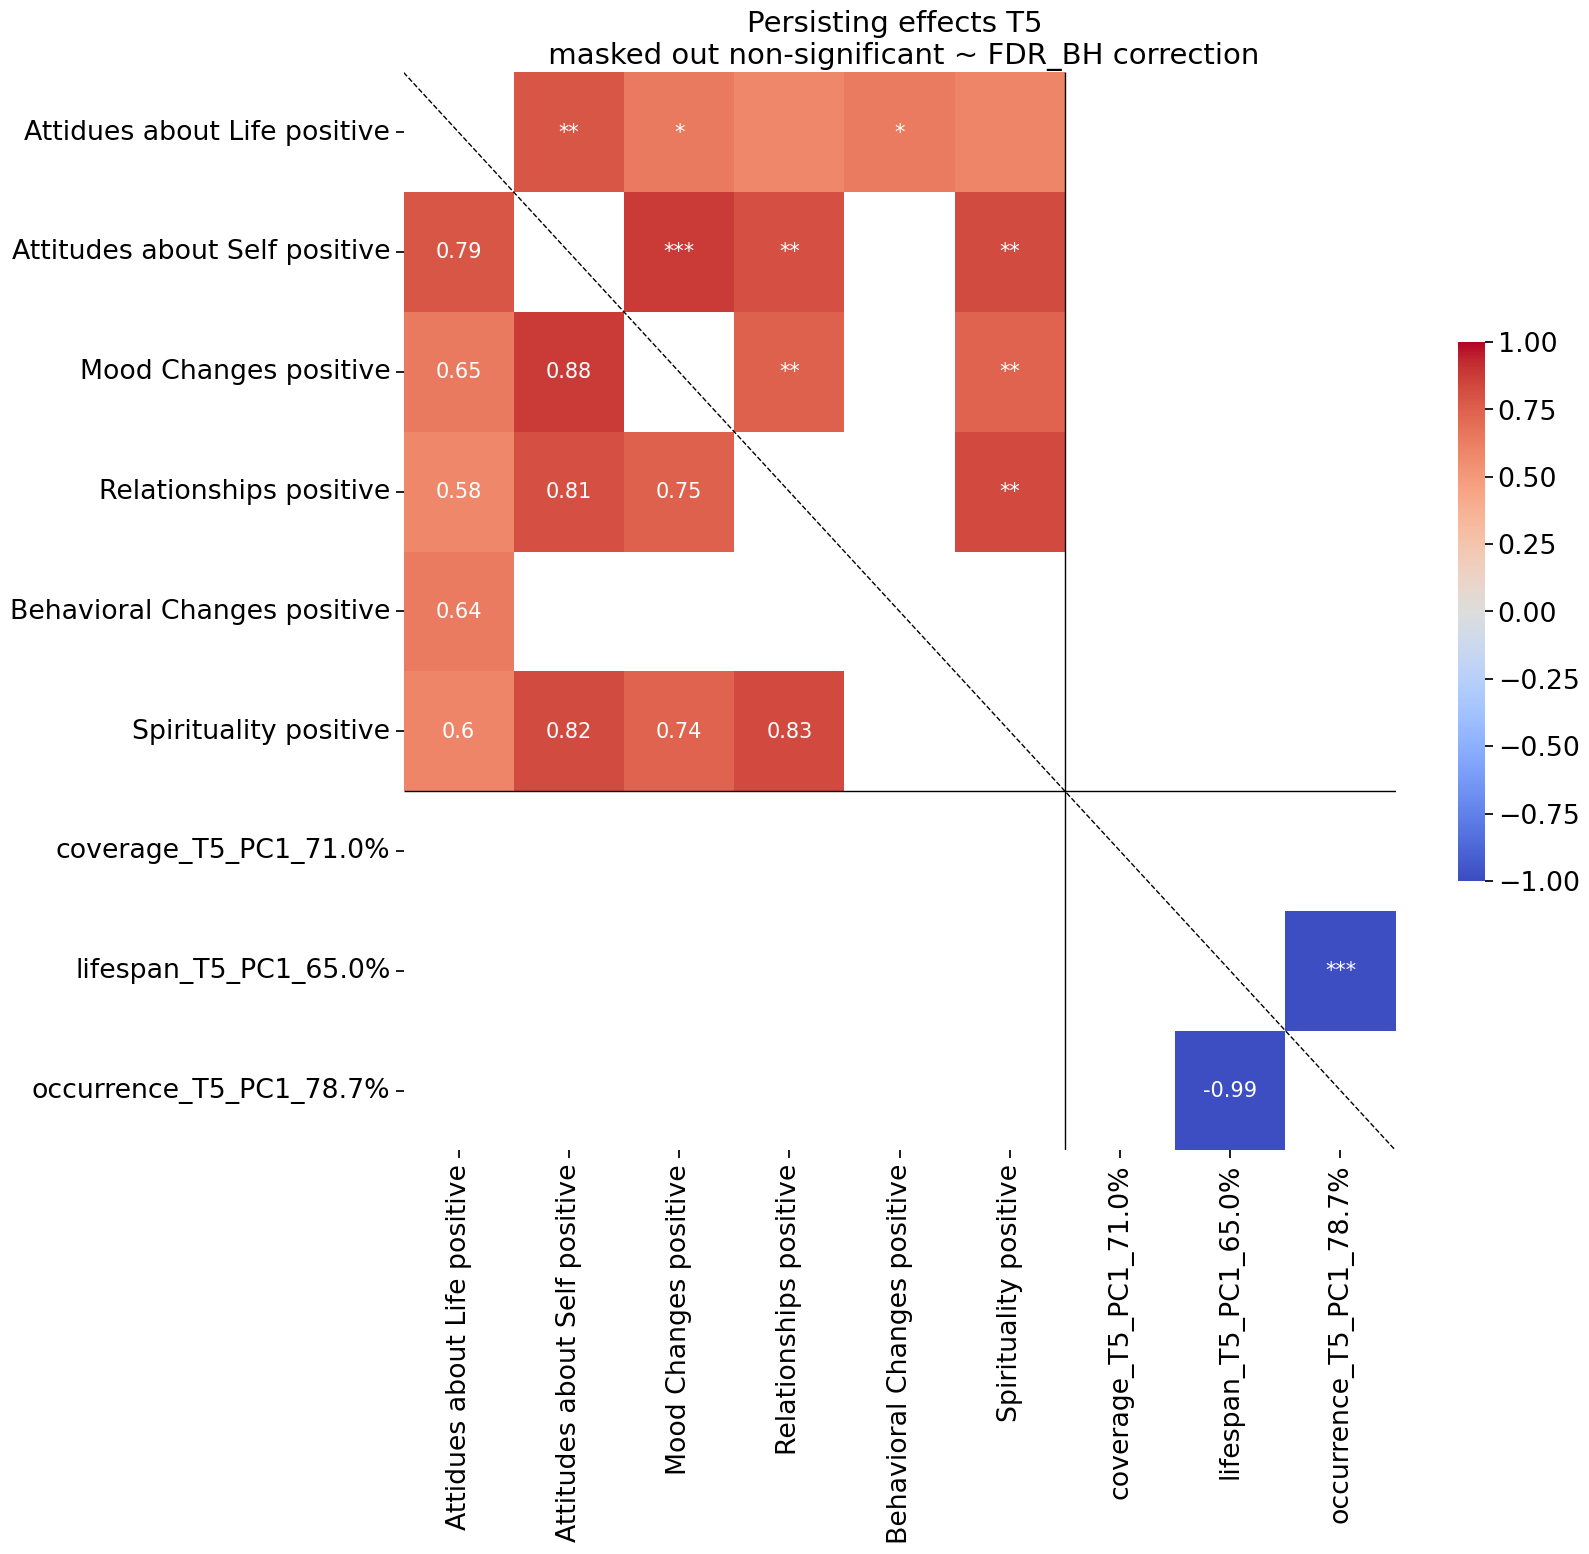

In [25]:
ms_stats_grp = (
    ms_stats[ms_stats["condition"] == "PSI"]
    .drop(["session", "ms_opts"], axis=1)
    .set_index(["subject", "condition", "time"])
)
groupings = ["coverage", "lifespan", "occurrence"]

for time in ["T2", "T3", "T4", "T5"]:
    ms_stats_grp_ = pd.DataFrame()
    for grp in groupings:
        pca_mat = pd_pca(
            ms_stats_grp[ms_stats_grp.index.get_level_values("time") == time]
            .reset_index()
            .pivot(index="subject", columns="microstate", values=grp),
            1,
            f"{grp}_{time}",
        )
        ms_stats_grp_ = pd.concat([ms_stats_grp_, pca_mat], axis=1)

    grp_corrs = pd.concat([persisting_effs_grp, ms_stats_grp_], axis=1)
    plot_corr(
        grp_corrs,
        method="spearman",
        mask_upper=False,
        mask_pval=True,
        lines=[6],
        title=f"Persisting effects {time} \n masked out non-significant ~ {MULTI_CORRECTION.upper()} correction",
        fname=f"persisting_effs_agg_{time}",
    )

In [26]:
experience_asc_conc = pd.concat(
    [experience_asc, experience_conc["PSI_conc_T60"]], axis=1
)
experience_asc_conc = experience_asc_conc[
    experience_asc_conc["condition"] == "PSI"
].drop("condition", axis=1)

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(


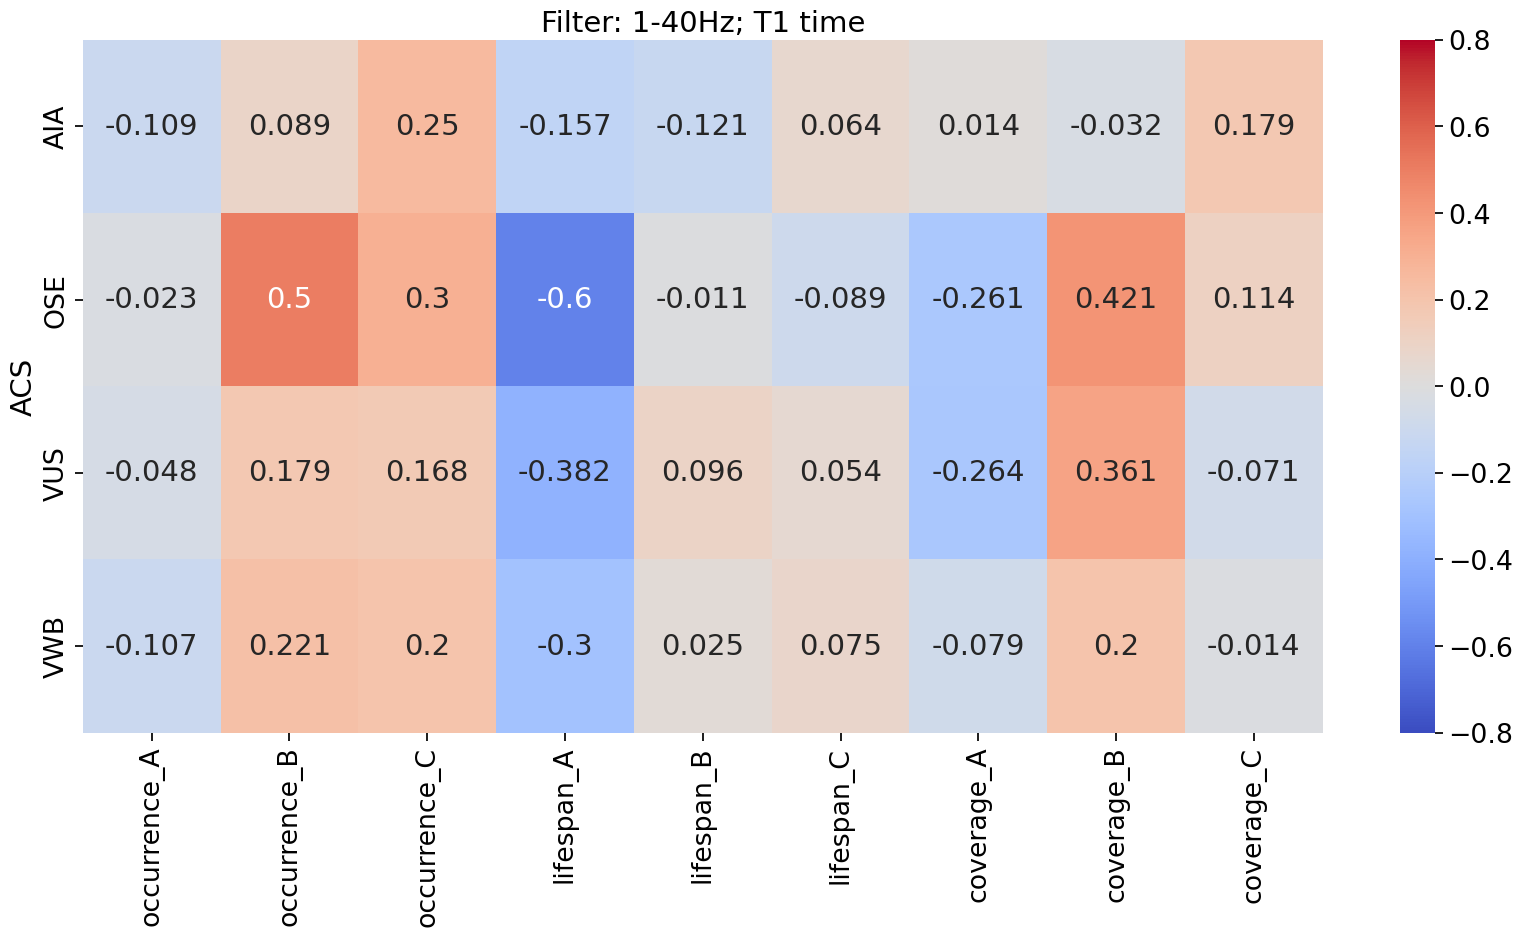

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(


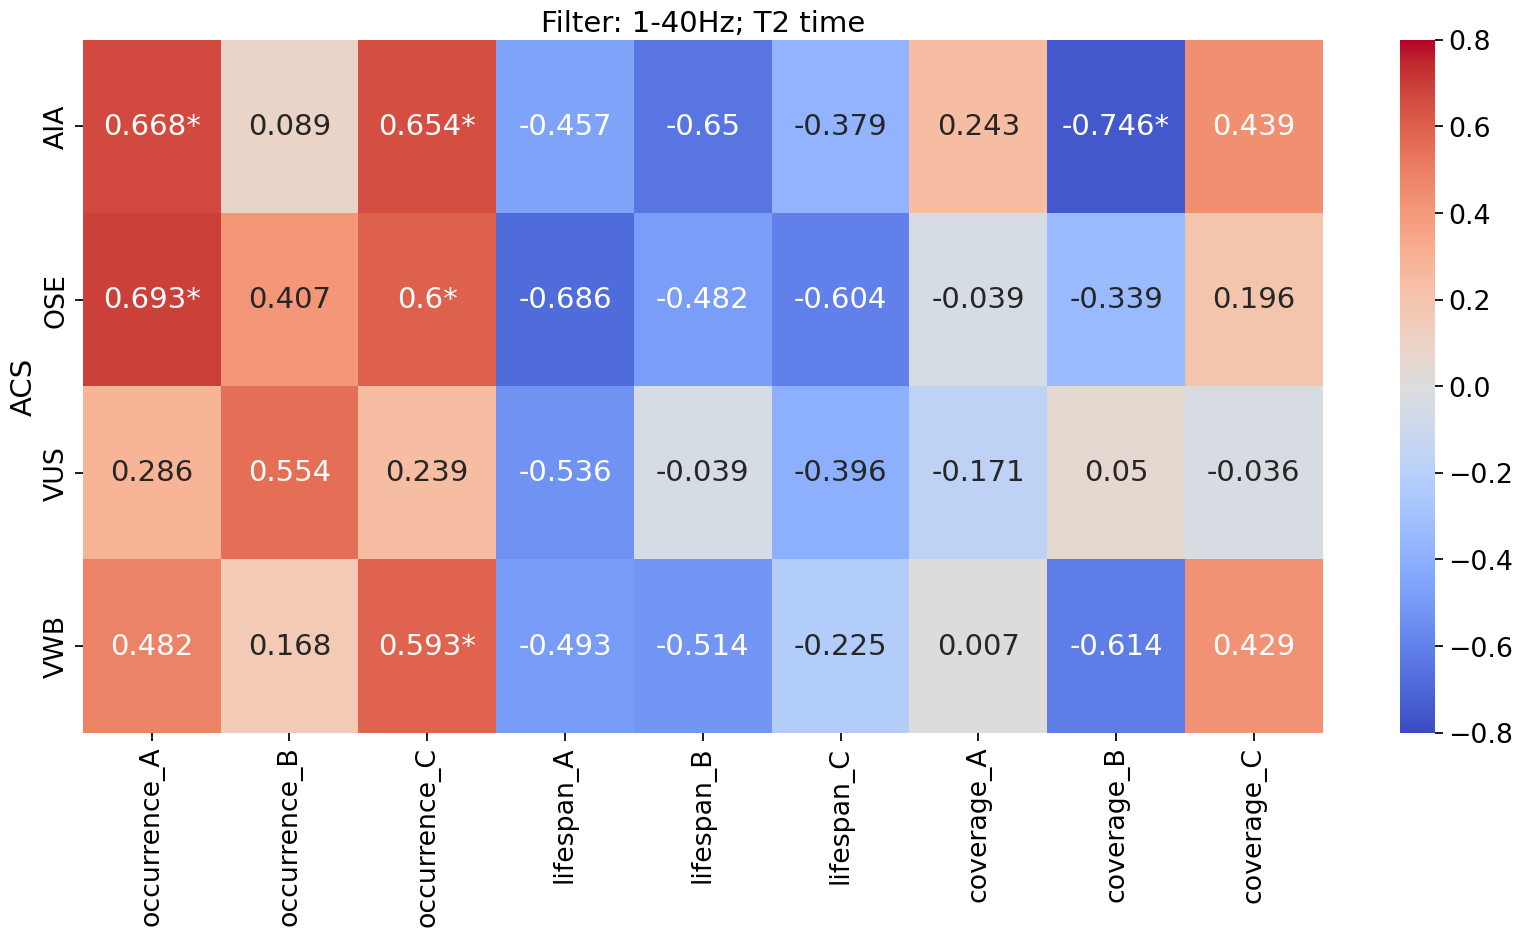

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(


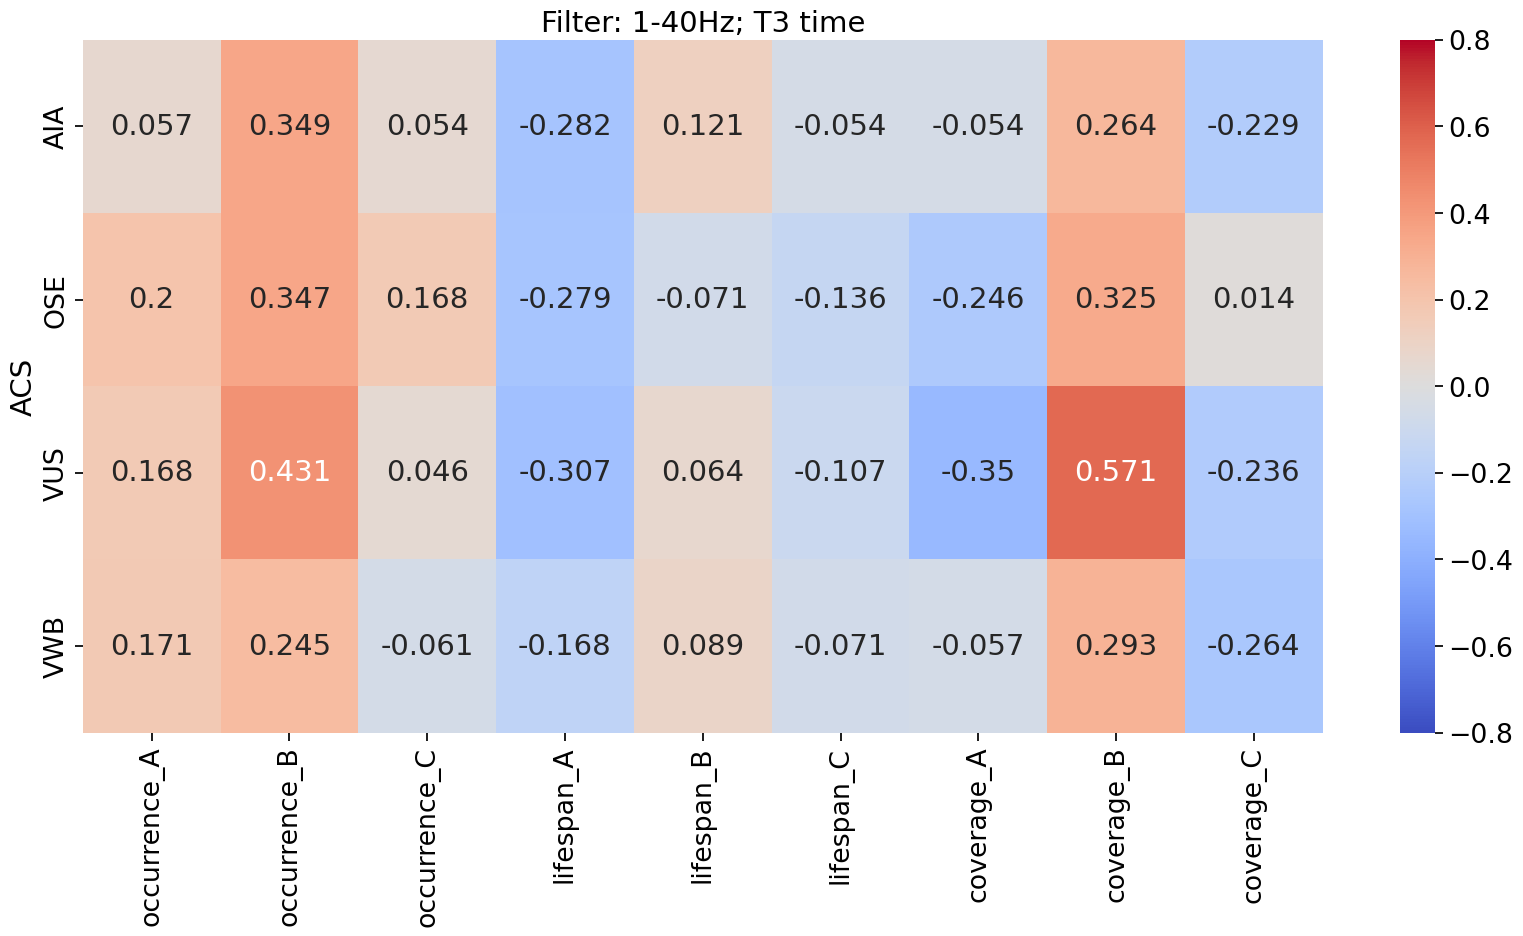

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(


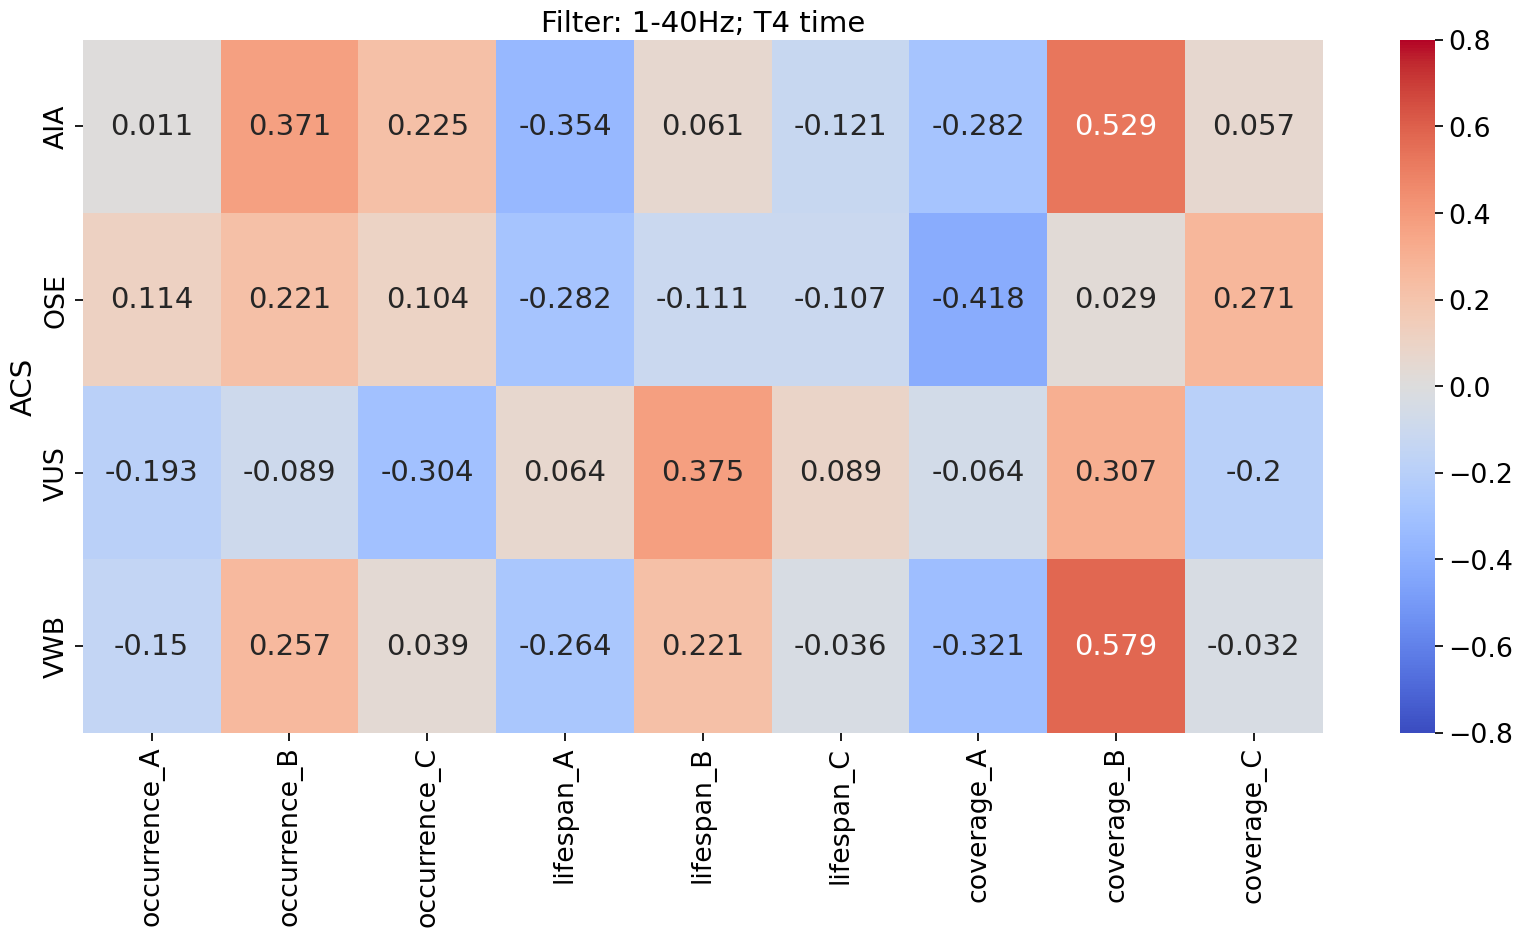

/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(
/var/folders/jb/6kk9qt8s72n9151lc4v96tn80000gn/T/ipykernel_60122/1035070614.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  .applymap(


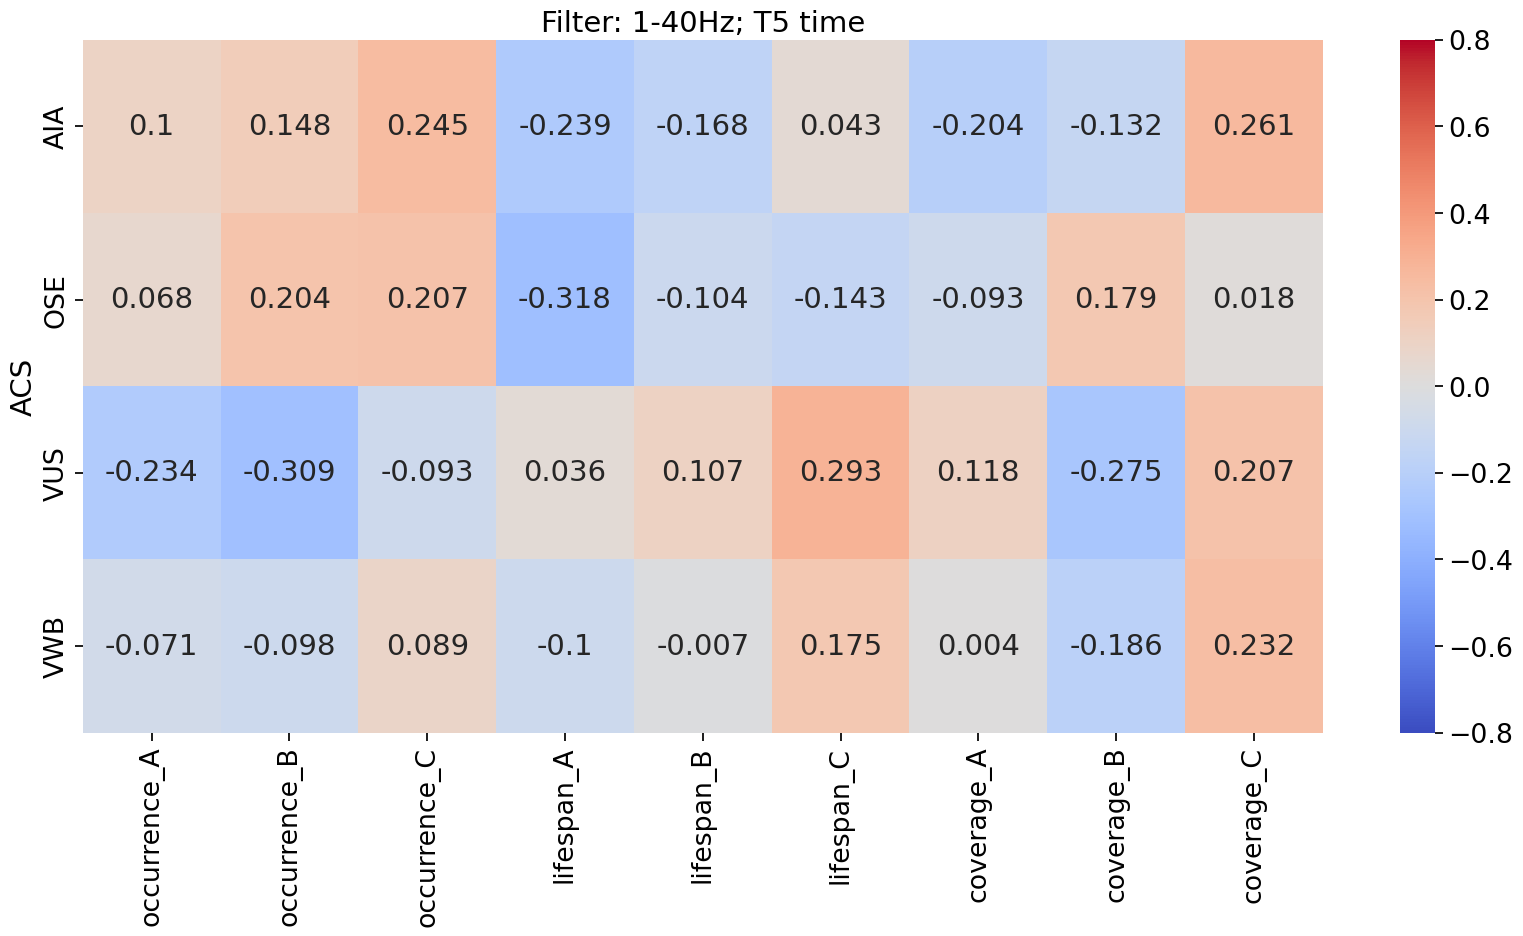

In [27]:
for time in np.unique(ms_stats["time"]):
    grand_r = pd.DataFrame()
    grand_annot = pd.DataFrame()

    for dv in ["occurrence", "lifespan", "coverage"]:
        df = ms_stats[ms_stats["condition"] == "PSI"][
            ["subject", "time", "microstate", dv]
        ]
        df = (
            df[df["time"] == time]
            .pivot(index="subject", columns="microstate", values=dv)
            .add_prefix(f"{dv}_")
        )
        df = pd.concat(
            [experience_asc_conc.reset_index(), df.reset_index()], axis=1
        )
        columns = [
            ["AIA", "OSE", "VUS", "VWB"],
            [f"{dv}_A", f"{dv}_B", f"{dv}_C"],
        ]
        corrs = pg.pairwise_corr(
            df,
            columns,
            method="spearman",
            padjust=MULTI_CORRECTION,
            alternative="two-sided",
        )
        r_vals = corrs.pivot(index="X", columns="Y", values="r")
        corr_stars = (
            corrs.pivot(index="X", columns="Y", values="p-corr")
            .round(3)
            .applymap(
                lambda x: "".join(["*" for st in PVAL_STARS.keys() if x < st])
            )
        )
        annot = r_vals.round(3).astype(str) + corr_stars
        grand_r = pd.concat([grand_r, r_vals], axis=1)
        grand_annot = pd.concat([grand_annot, annot], axis=1)
    plt.figure()
    sns.heatmap(
        grand_r, cmap="coolwarm", vmax=0.8, vmin=-0.8, annot=grand_annot, fmt=""
    )
    plt.ylabel("ACS")
    plt.xlabel("")
    plt.title(f"Filter: 1-40Hz; {time} time")
    plt.show()